# **Final Project Submission**

## Group 10

## Instructor - Christine Kirimi

# **STRATEGIC FILM INVESTMENT ANALYSIS**

![](moviestudio.jpg)

# **Overview**


The entertainment landscape is dominated by established studios with decades of experience and brand recognition. Our company seeks to enter this competitive market by launching a new movie studio.
The primary challenge is the inherent risk and uncertainty in film production. To mitigate this risk and make informed strategic decisions, we need to base our initial creative and financial choices on data rather than intuition alone.

# **Business Understanding**
**Business Problem:** Which films perform best at the box office today?  

**Objectives:**  
1. Genres: Pinpoint profitable genres.

    Which movie genres demonstrate the strongest and most consistent combination of high financial return and audience appeal?

2. Budget: Recommend a budget.

    What is the optimal production budget range that maximizes return on investment (ROI) for a new entrant?

3. Strategy: Uncover success strategy.

    What other factors—such as release season, runtime, or franchise potential—are correlated with success and should influence our decision-making?





The analysis will involve acquiring, cleaning, merging, and exploring these datasets to uncover meaningful patterns that address the business problem.


# **Data Understanding and Exploration**

We are working with these datasets:  
1. `IMDb Database(im.db)`: Contains detailed information on movies, including genres, runtimes, average ratings, and number of votes.

2. `Box Office Mojo Data`: Provides financial data, including domestic and international gross revenue.

3. `The Numbers Budget Data`: Contains production budget information, which is crucial for calculating profitability.

4. `Rotten Tomatoes Data`: Offers critic and audience scores as measures of reception and popularity.

Key variables: Genre, Rating, Runtime, Release Year, Box Office Revenue

In [60]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from matplotlib.ticker import FuncFormatter 

import warnings

# Filter out FutureWarnings 
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

# Set Seaborn style for enhanced aesthetics
sns.set_style("whitegrid", {"grid.linestyle": "--", "grid.color": "0.8"})
sns.set_context("notebook", font_scale=1.2)

## 1. Connecting to the Database and Initial Exploration

In [61]:
# Inspecting what is inside the 'im.db.zip'
zip_path = "zippedData/im.db.zip"

try:
    with zipfile.ZipFile(zip_path, 'r') as z:
        print("Files inside the ZIP:", z.namelist())
except FileNotFoundError:
    print("Error: ZIP file not found at", zip_path)


Files inside the ZIP: ['im.db']


In [62]:
# Define the path to the zipped database file
zip_file_path = 'zippedData/im.db.zip'

# Define the directory where the database file will be extracted
extracted_dir = 'unzipped/imdb_db'

# Define the path to the database file after extraction
db_file_path = os.path.join(extracted_dir, 'im.db')

# Create the extraction directory if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)

# Extract the database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print(f"Successfully extracted {len(zip_ref.namelist())} file(s) to {extracted_dir}")

Successfully extracted 1 file(s) to unzipped/imdb_db


In [63]:
# Connect to the SQLite database
conn = sqlite3.connect(db_file_path)

# Get list of tables
tables = pd.read_sql("""
                     SELECT name
                     FROM sqlite_master
                     WHERE type='table';
                     """, conn)
print("Tables in the IMDb database:")
print(tables)

Tables in the IMDb database:
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


## 2. Examining Key Tables: movie_basics and movie_ratings

### These two tables are most critical for our high-level analysis. Let's examine their structure and content.

In [64]:
# Examine the movie_basics table structure
movie_basics_info = pd.read_sql("PRAGMA table_info(movie_basics);", conn)
print("Movie Basics Table Schema:")
print(movie_basics_info)

Movie Basics Table Schema:
   cid             name     type  notnull dflt_value  pk
0    0         movie_id     TEXT        0       None   0
1    1    primary_title     TEXT        0       None   0
2    2   original_title     TEXT        0       None   0
3    3       start_year  INTEGER        0       None   0
4    4  runtime_minutes     REAL        0       None   0
5    5           genres     TEXT        0       None   0


In [65]:
# Examine the movie_ratings table structure
movie_ratings_info = pd.read_sql("PRAGMA table_info(movie_ratings);", conn)
print("\nMovie Ratings Table Schema:")
print(movie_ratings_info)


Movie Ratings Table Schema:
   cid           name     type  notnull dflt_value  pk
0    0       movie_id     TEXT        0       None   0
1    1  averagerating     REAL        0       None   0
2    2       numvotes  INTEGER        0       None   0


### Now let's look at sample data from these tables:

In [66]:
# Get sample data from movie_basics
basics_sample = pd.read_sql("""
                            SELECT *
                            FROM movie_basics
                            LIMIT 5;
                            """, conn)
print("Sample from movie_basics:")
print(basics_sample)

Sample from movie_basics:
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  


In [67]:
# Get sample data from movie_ratings
ratings_sample = pd.read_sql("""
                             SELECT *
                             FROM movie_ratings
                             LIMIT 5;
                             """, conn)
print("\nSample from movie_ratings:")
print(ratings_sample)


Sample from movie_ratings:
     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt1060240            6.5        21


## 3. Merging the Key Tables and Initial Data Quality Check
### Let's merge the two tables and examine the combined dataset.

In [68]:
# Merge the two main tables
# Dropping 'Original Title' column and using only the 'Primary Title'
query = """
        SELECT b.movie_id, b.primary_title, b.start_year,
               b.runtime_minutes, b.genres,
               r.averagerating, r.numvotes
        FROM movie_basics b
        JOIN movie_ratings r
        ON b.movie_id = r.movie_id;
        """

imdb_df = pd.read_sql_query(query, conn)
print(f"Merged dataset shape: {imdb_df.shape}")
print("\nFirst 5 rows of merged dataset:")
print(imdb_df.head())

Merged dataset shape: (73856, 7)

First 5 rows of merged dataset:
    movie_id                    primary_title  start_year  runtime_minutes  \
0  tt0063540                        Sunghursh        2013            175.0   
1  tt0066787  One Day Before the Rainy Season        2019            114.0   
2  tt0069049       The Other Side of the Wind        2018            122.0   
3  tt0069204                  Sabse Bada Sukh        2018              NaN   
4  tt0100275         The Wandering Soap Opera        2017             80.0   

                 genres  averagerating  numvotes  
0    Action,Crime,Drama            7.0        77  
1       Biography,Drama            7.2        43  
2                 Drama            6.9      4517  
3          Comedy,Drama            6.1        13  
4  Comedy,Drama,Fantasy            6.5       119  


In [69]:
# Check basic info and missing values
print("\nDataset Info:")
print(imdb_df.info())
print("\nMissing Values:")
print(imdb_df.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   start_year       73856 non-null  int64  
 3   runtime_minutes  66236 non-null  float64
 4   genres           73052 non-null  object 
 5   averagerating    73856 non-null  float64
 6   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ MB
None

Missing Values:
movie_id              0
primary_title         0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64


## 4. Handling Missing Values and Data Cleaning
### Based on the missing values analysis, we need to clean our data

In [70]:
# Display percentage of missing values
print("Percentage of missing values:")
print((imdb_df.isnull().sum() / len(imdb_df) * 100).round(2))

Percentage of missing values:
movie_id            0.00
primary_title       0.00
start_year          0.00
runtime_minutes    10.32
genres              1.09
averagerating       0.00
numvotes            0.00
dtype: float64


In [71]:
# Learning more about the shape and spread of the runtime_minutes data
# Basic statistics, info about runtime data
print("Runtime data overview:")
print(imdb_df['runtime_minutes'].describe())

# Look at percentiles to understand spread
print("\nPercentiles:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = imdb_df['runtime_minutes'].quantile(p/100)
    print(f"{p}th percentile: {value}")

Runtime data overview:
count    66236.000000
mean        94.654040
std        208.574111
min          3.000000
25%         81.000000
50%         91.000000
75%        104.000000
max      51420.000000
Name: runtime_minutes, dtype: float64

Percentiles:
10th percentile: 69.0
25th percentile: 81.0
50th percentile: 91.0
75th percentile: 104.0
90th percentile: 120.0
95th percentile: 135.0
99th percentile: 161.0


In [72]:
# Since the column is right-skewed(mean>median i.e 94>91) and 
# the 99th percentile is 161.0 but max is 51420, suggests extreme outliers would skew the mean.
# → Median becomes more robust choice for filling nulls.
# For runtime_minutes, we'll fill with median value.

runtime_median = imdb_df['runtime_minutes'].median()
imdb_df['runtime_minutes'].fillna(runtime_median, inplace=True)

# Drop remaining rows with missing values, that is 1%
imdb_df.dropna(subset=['genres'], inplace=True)

print(f"\nDataset shape after handling missing values: {imdb_df.shape}")


Dataset shape after handling missing values: (73052, 7)


# **Data Analysis**

## 5. Exploratory Data Analysis
### Now let's explore the data to gain insights.

#### 5.1 Distribution of Movie Ratings

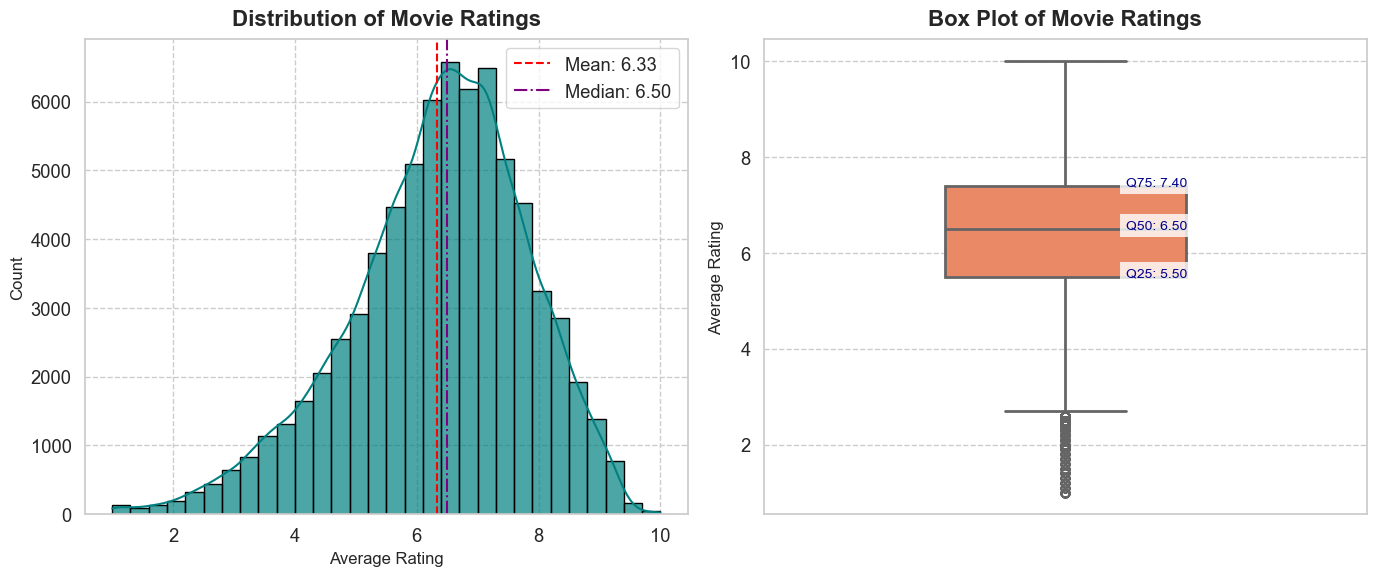

Rating Statistics:
count    73052.000000
mean         6.330930
std          1.474699
min          1.000000
25%          5.500000
50%          6.500000
75%          7.400000
max         10.000000
Name: averagerating, dtype: float64


In [73]:
# Create a figure with two subplots
plt.figure(figsize=(14, 6), facecolor='white')

# Histogram with KDE
plt.subplot(1, 2, 1)
sns.histplot(data=imdb_df, x='averagerating', bins=30, kde=True, color='teal', edgecolor='black', alpha=0.7)
plt.title('Distribution of Movie Ratings', fontsize=16, weight='bold', pad=10)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add mean and median lines
mean_rating = imdb_df['averagerating'].mean()
median_rating = imdb_df['averagerating'].median()
plt.axvline(mean_rating, color='red', linestyle='--', label=f'Mean: {mean_rating:.2f}')
plt.axvline(median_rating, color='purple', linestyle='-.', label=f'Median: {median_rating:.2f}')
plt.legend()

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=imdb_df['averagerating'], color='coral', width=0.4, linewidth=2)
plt.title('Box Plot of Movie Ratings', fontsize=16, weight='bold', pad=10)
plt.ylabel('Average Rating', fontsize=12)

# Add annotations for quartiles
quartiles = imdb_df['averagerating'].quantile([0.25, 0.5, 0.75])
for q, val in quartiles.items():
    plt.text(0.1, val, f'Q{int(q*100)}: {val:.2f}', fontsize=10, color='darkblue', 
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print rating statistics
print("Rating Statistics:")
print(imdb_df['averagerating'].describe())

In [74]:
#📌 Insights:
# Histogram: Bars show the count (frequency) of movie ratings. The peak is between 6 and 7, where most ratings fall. Skewed to the left; mean<median
# Box Plot: The box is not centered—it stretches more to the top (7.4) than to the bottom (5.5), but the whisker below the box is longer (1.0 to 5.5), 
#           indicating a tail on the left. There are many outliers below the lower whisker (left-side extreme values).

#### 5.2 Distribution of Number of Votes

In [75]:
# Learning more about the shape and spread of the number_of_votes data
# Basic statistics, info about number_of_votes data
print("Number of Votes overview:")
print(imdb_df['numvotes'].describe())

# Look at percentiles to understand spread
print("\nPercentiles:")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    value = imdb_df['numvotes'].quantile(p/100)
    print(f"{p}th percentile: {value}")

Number of Votes overview:
count    7.305200e+04
mean     3.562173e+03
std      3.045804e+04
min      5.000000e+00
25%      1.400000e+01
50%      5.000000e+01
75%      2.890000e+02
max      1.841066e+06
Name: numvotes, dtype: float64

Percentiles:
10th percentile: 7.0
25th percentile: 14.0
50th percentile: 50.0
75th percentile: 289.0
90th percentile: 1620.0
95th percentile: 5707.899999999994
99th percentile: 84715.26000000039


In [76]:
#📌 Insights:
# Count data like numvotes, the distribution is highly skewed, mean is way greater then median; heavily rightly skewed. i.e 
#      some movies have millions of votes, others have just a few. Without logs, box plots get dominated by large values, and smaller ones get squashed.
#     Log scale compresses the range, making plots readable and comparisons fair.

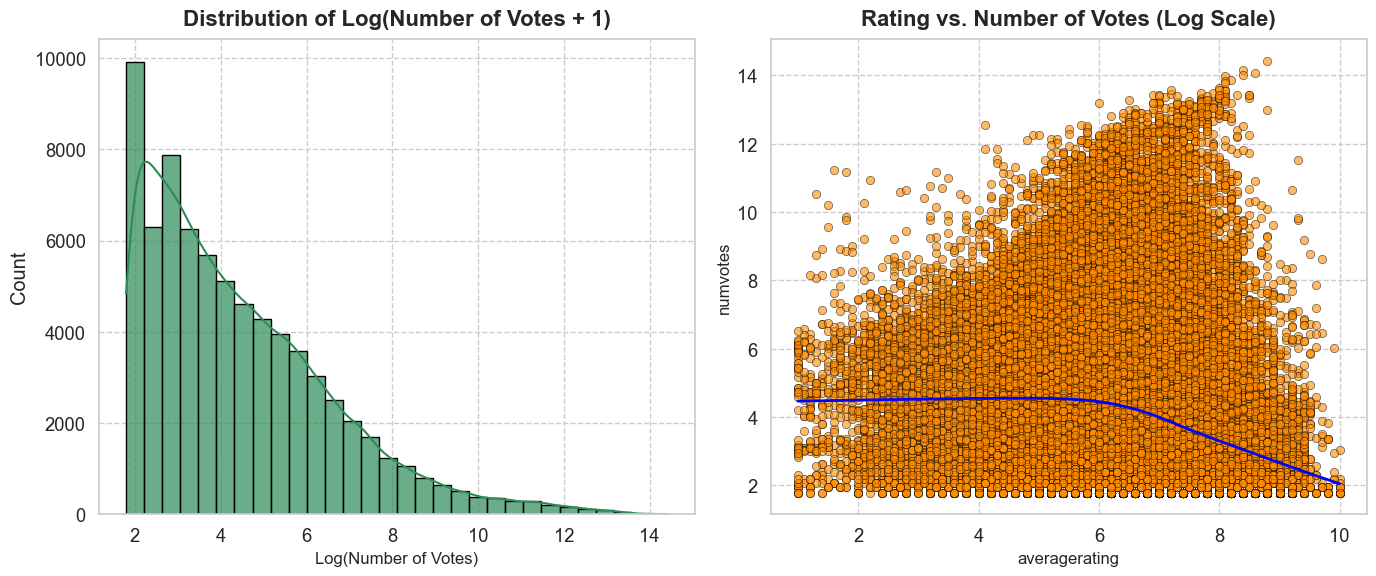

In [77]:
plt.figure(figsize=(14, 6), facecolor='white')

# Histogram with KDE for log(number of votes + 1)
plt.subplot(1, 2, 1)
sns.histplot(data=np.log1p(imdb_df['numvotes']), bins=30, kde=True, color='seagreen', edgecolor='black', alpha=0.7)

# log1p = log(x+1)
# Wewe use log(x + 1) instead of log(x) to handle zero values safely. The logarithm of 0 is undefined: log(0)=−∞ and may crash the 0 votes entries.

plt.title('Distribution of Log(Number of Votes + 1)', fontsize=16, weight='bold', pad=10)
plt.xlabel('Log(Number of Votes)', fontsize=12)

# Scatter Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=imdb_df['averagerating'], y=np.log1p(imdb_df['numvotes']), color='darkorange', alpha=0.6, edgecolor='black', linewidth=0.5)
plt.title('Rating vs. Number of Votes (Log Scale)', fontsize=16, weight='bold', pad=10)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Log(Number of Votes)', fontsize=12)

# Add a trend line (lowess)
sns.regplot(x=imdb_df['averagerating'], y=np.log1p(imdb_df['numvotes']), lowess=True, scatter=False, color='blue', line_kws={'linewidth': 2, 'label': 'Trend'})

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [78]:
# HISTOGTRAM:
# The log scale compresses the high-end outliers, letting us see the true shape of the majority of the data.
# Most movies have low to moderate vote counts, while a small number have very high votes — which becomes visible only after using log scaling.

# SCATTER PLOT
# The plot shows how number of votes varies with rating, but on a log scale to handle the skew.
# The blue LOWESS line gives us the general trend:It increases from low ratings (~1–5.5) → More popular movies tend to have mid to high ratings.
# Peaks around 6–7. Declines slightly after 7–8, suggesting that very highly rated movies (8–10) are not necessarily the most voted.
# This suggests that the most commonly voted movies tend to have mid-to-high ratings, not necessarily the highest ones.

#📌 Insights:
# Very low-rated movies get fewer votes — maybe due to poor exposure or niche appeal.
# Very high-rated movies might also get fewer votes, possibly due to being less mainstream or newer.
# Mid-range popular movies (6–7) likely get more votes due to broader appeal or larger audiences.

#### 5.3 Movies Over Time

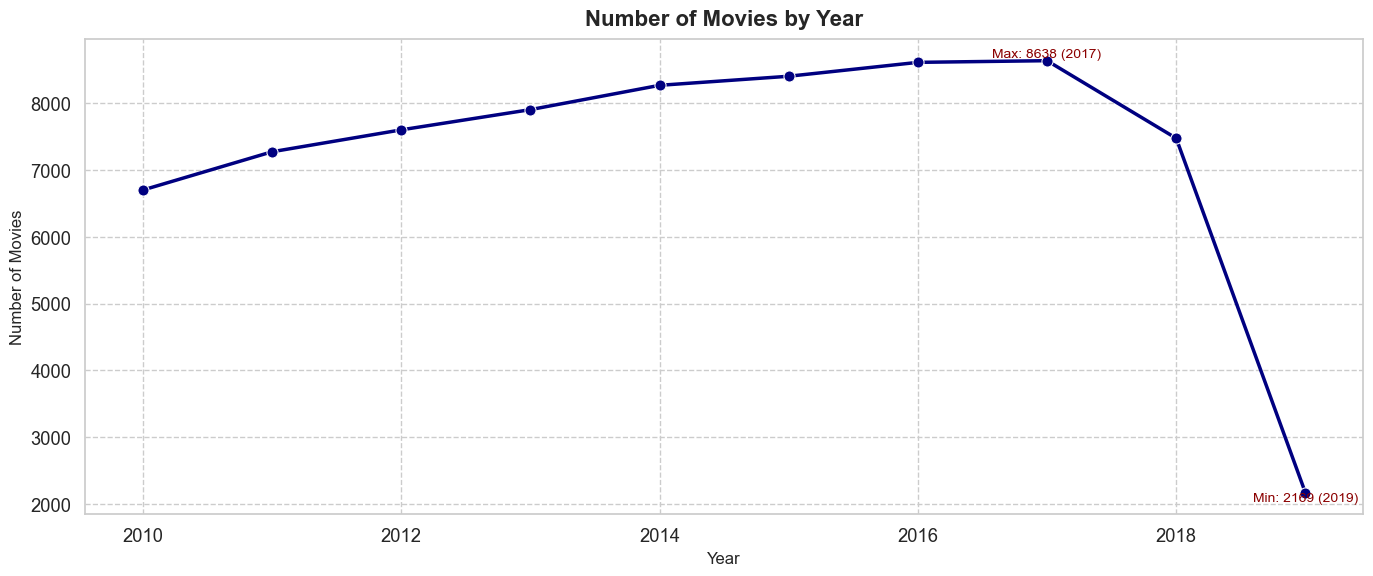

Number of movies since 2000: 73052


In [79]:
# Group movies by year
movies_by_year = imdb_df.groupby('start_year').size()

# Create a figure
plt.figure(figsize=(14, 6), facecolor='white')

# Line plot with Seaborn
sns.lineplot(x=movies_by_year.index, y=movies_by_year.values, color='navy', linewidth=2.5, marker='o', markersize=8)
plt.title('Number of Movies by Year', fontsize=16, weight='bold', pad=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Movies', fontsize=12)

# Add annotations for max and min points
max_year = movies_by_year.idxmax()
max_value = movies_by_year.max()
min_year = movies_by_year.idxmin()
min_value = movies_by_year.min()
plt.text(max_year, max_value, f'Max: {max_value} ({max_year})', fontsize=10, color='darkred', ha='center', va='bottom')
plt.text(min_year, min_value, f'Min: {min_value} ({min_year})', fontsize=10, color='darkred', ha='center', va='top')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Filter for recent years (2000 onwards) and print count
recent_movies = imdb_df[imdb_df['start_year'] >= 2000]
print(f"Number of movies since 2000: {len(recent_movies)}")

In [80]:
# 🔎 Why the sudden drop?
# This is likely due to data incompleteness or lags in metadata for recent years in your dataset — a very common issue when using open datasets like IMDb.
# Not a true reflection of actual movie production.
# Alternatively, COVID-19 (starting in late 2019) might have affected 2020/2021 data more, but the drop in 2019 might still reflect pre-pandemic metadata gaps.

#### 5.4 Genre Analysis

In [81]:
# Analyze genres - first need to split the genres column
# Create a list of all genres
all_genres = []
for genres in imdb_df['genres'].dropna():
    all_genres.extend(genres.split(','))

# Count frequency of each genre
from collections import Counter
genre_counts = Counter(all_genres)

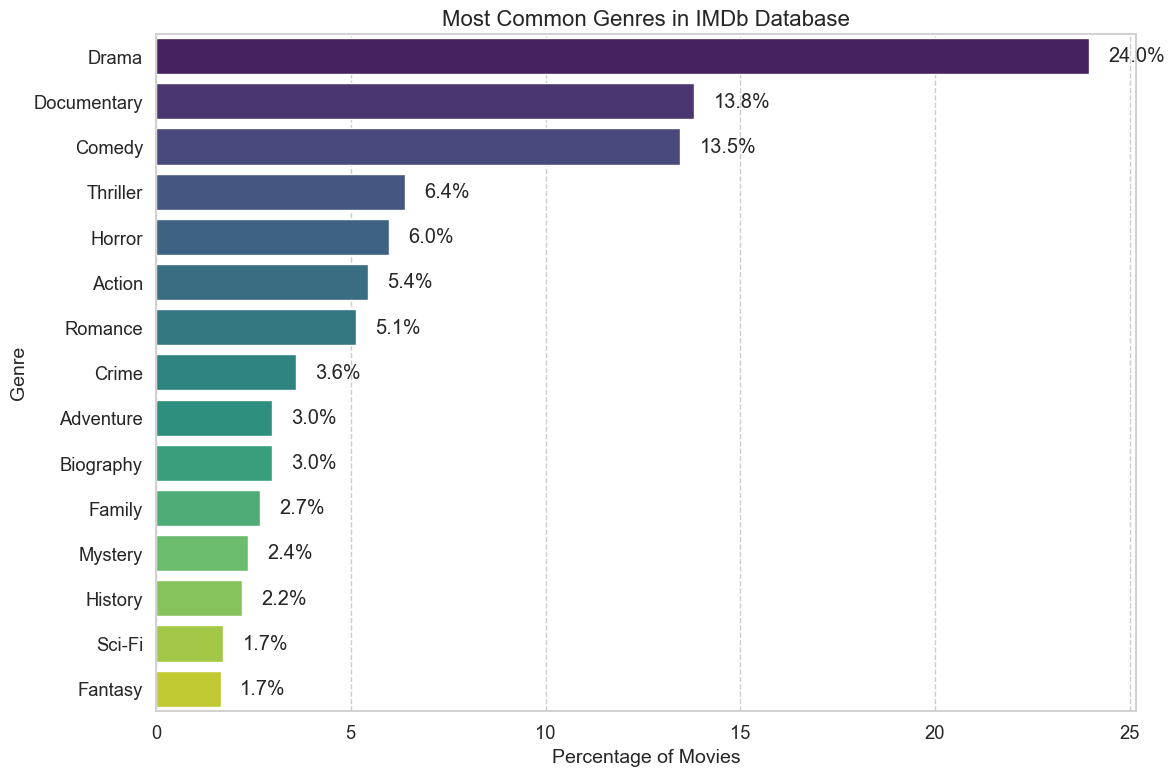

In [82]:
genre_series = pd.Series(genre_counts)

# Get the top 15 most common genres
top_genres = genre_series.sort_values(ascending=False).head(15)

# Convert counts to percentages
top_genres_pct = (top_genres / genre_series.sum()) * 100

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x=top_genres_pct.values,
    y=top_genres_pct.index,
    palette="viridis"
)

# Add percentages as labels on each bar
for i, (value, label) in enumerate(zip(top_genres_pct.values, top_genres_pct.index)):
    ax.text(value + 0.5, i, f"{value:.1f}%", va="center")

plt.title("Most Common Genres in IMDb Database", fontsize=16)
plt.xlabel("Percentage of Movies", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.tight_layout()
plt.show()

In [83]:
#📌 Insights: Note that the top 3 genres make up more than 50% of the genre

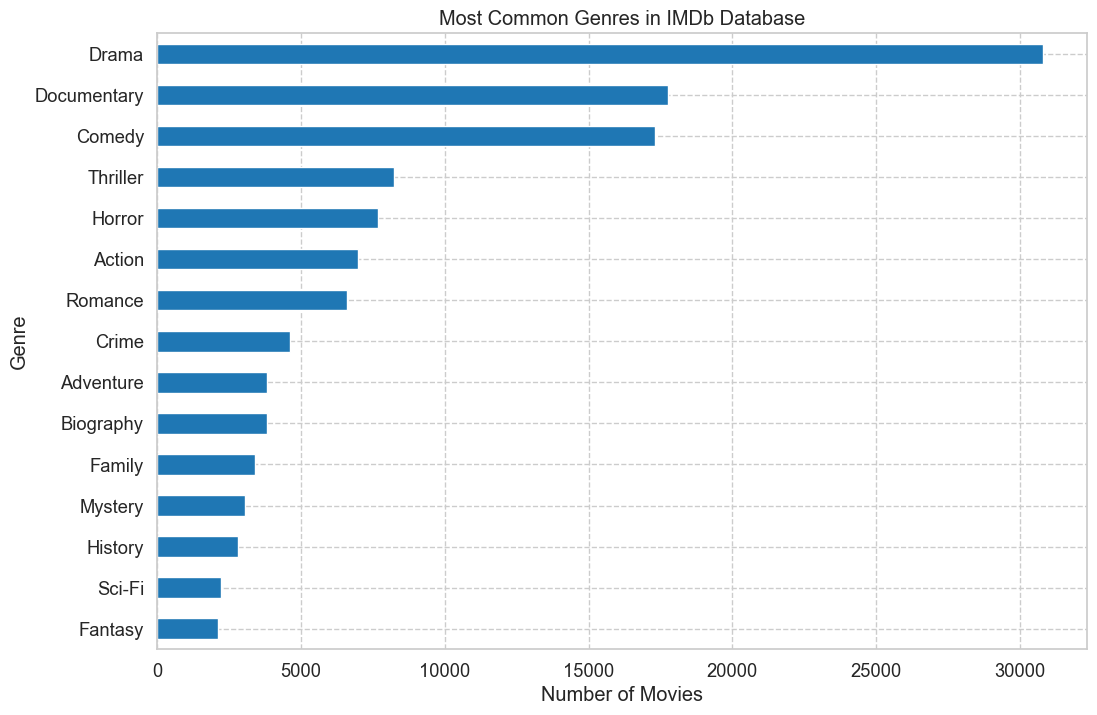

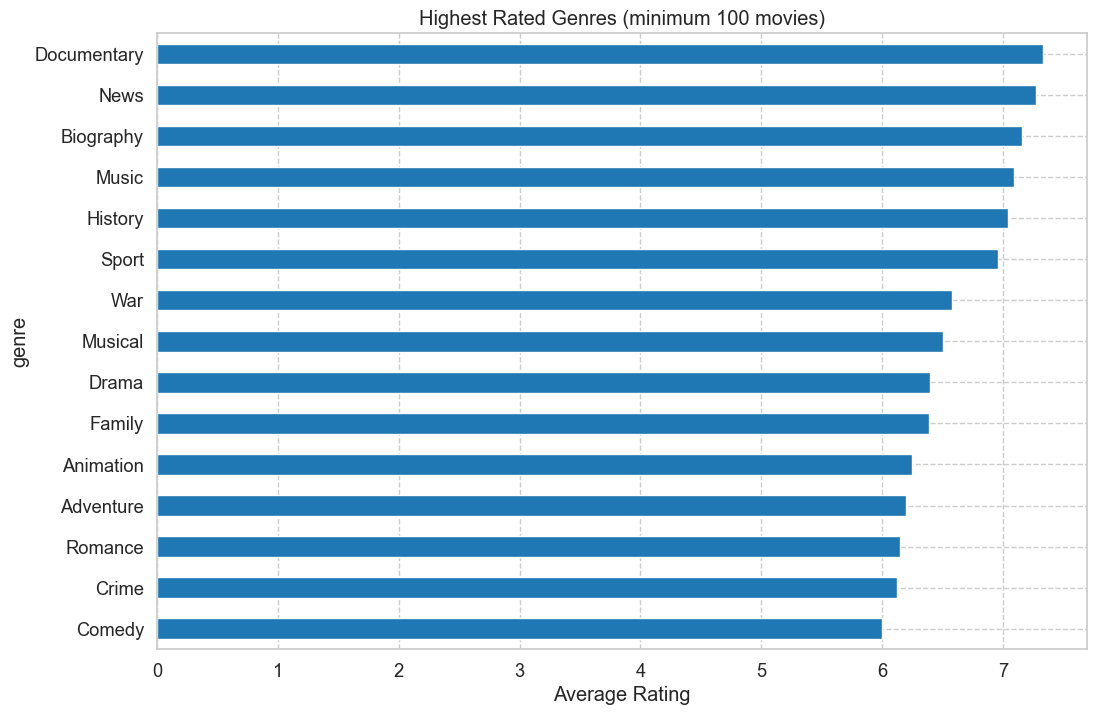

In [84]:
# Analyze genres - first need to split the genres column
# Create a list of all genres
all_genres = []
for genres in imdb_df['genres'].dropna():
    all_genres.extend(genres.split(','))

# Count frequency of each genre
from collections import Counter
genre_counts = Counter(all_genres)

# Plot most common genres - Visual 1
plt.figure(figsize=(12, 8))
pd.Series(genre_counts).sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Most Common Genres in IMDb Database')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

# Analyze average rating by genre
# First, create a dataframe where each genre is separated
genre_ratings = []
for _, row in imdb_df.iterrows():
    if pd.notna(row['genres']):
        for genre in row['genres'].split(','):
            genre_ratings.append({
                'genre': genre,
                'rating': row['averagerating'],
                'votes': row['numvotes']
            })

genre_ratings_df = pd.DataFrame(genre_ratings)

# Calculate weighted average by number of votes
genre_stats = genre_ratings_df.groupby('genre').agg({
    'rating': ['mean', 'count'],
    'votes': 'sum'
}).round(2)

genre_stats.columns = ['avg_rating', 'movie_count', 'total_votes']
genre_stats = genre_stats[genre_stats['movie_count'] > 100]  # Filter for genres with sufficient movies

# Plot average rating by genre - Visual 2
plt.figure(figsize=(12, 8))
genre_stats.sort_values('avg_rating', ascending=True)['avg_rating'].tail(15).plot(kind='barh')
plt.title('Highest Rated Genres (minimum 100 movies)')
plt.xlabel('Average Rating')
plt.show()

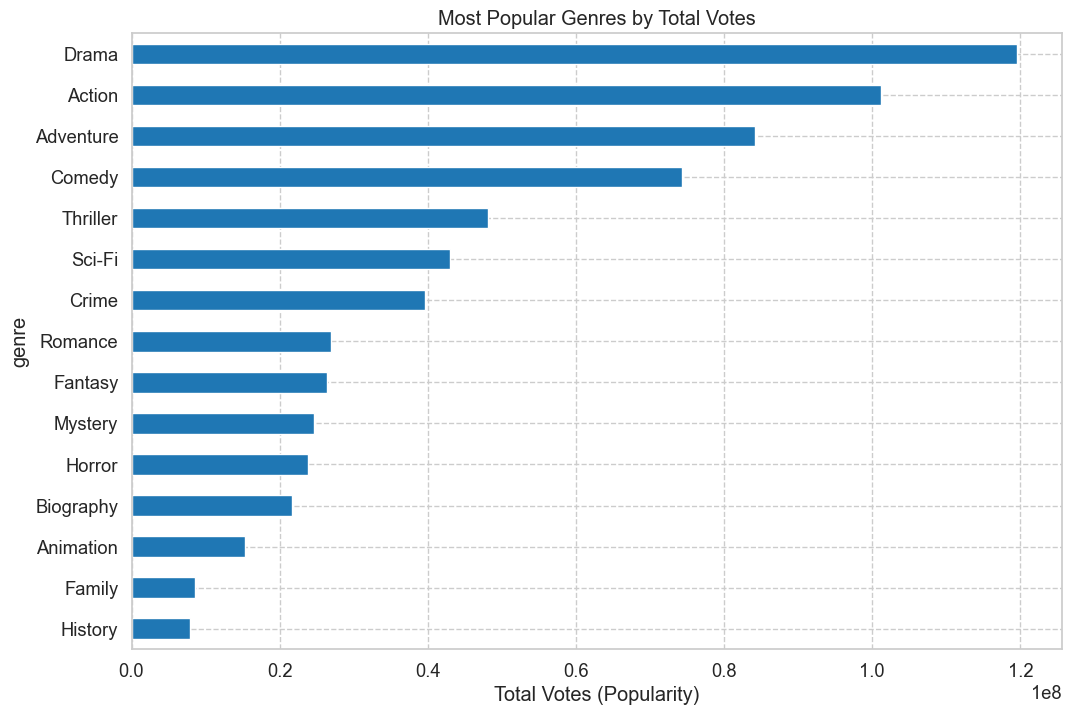

In [85]:
# Plot most popular genres by number of votes - Visual 3
plt.figure(figsize=(12, 8))
genre_stats.sort_values('total_votes', ascending=True)['total_votes'].tail(15).plot(kind='barh')  
plt.title('Most Popular Genres by Total Votes')
plt.xlabel('Total Votes (Popularity)')
plt.show()

#### 5.5 Runtime Analysis

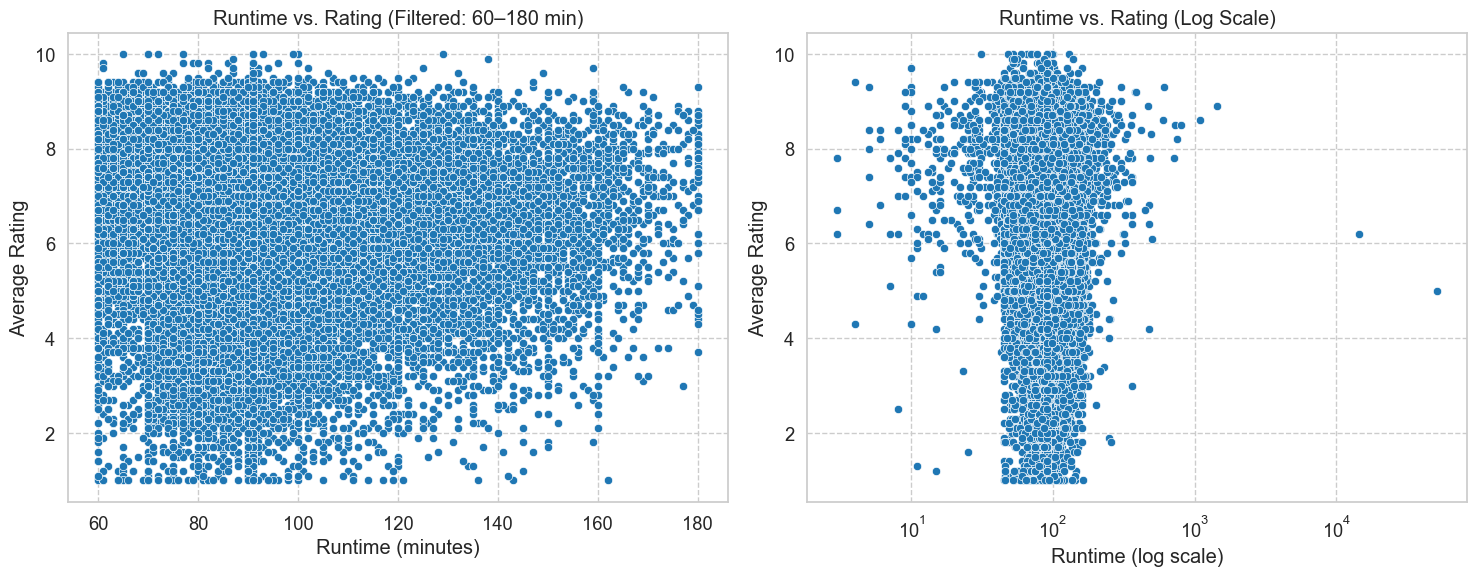

Movies with runtime between 60-180 minutes: 69135
Percentage of movies with reasonable runtime (60–180 min): 94.64%
Correlation between runtime and rating: 0.011


In [86]:
# Create reasonable runtime filter (60–180 minutes)
reasonable_runtime = imdb_df[
    (imdb_df['runtime_minutes'] >= 60) & 
    (imdb_df['runtime_minutes'] <= 180)
]

# Plot both filtered and full data with log scale
plt.figure(figsize=(15, 6))

# Plot 1: Filtered data (no log scale)
plt.subplot(1, 2, 1)
sns.scatterplot(data=reasonable_runtime, x='runtime_minutes', y='averagerating')
plt.title('Runtime vs. Rating (Filtered: 60–180 min)')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')

# Plot 2: All data (log scale)
plt.subplot(1, 2, 2)
sns.scatterplot(data=imdb_df, x='runtime_minutes', y='averagerating')
plt.xscale('log')
plt.title('Runtime vs. Rating (Log Scale)')
plt.xlabel('Runtime (log scale)')
plt.ylabel('Average Rating')

plt.tight_layout()
plt.show()

# Filter out extreme runtimes for better analysis
reasonable_runtime = imdb_df[(imdb_df['runtime_minutes'] >= 60) & (imdb_df['runtime_minutes'] <= 180)]
print(f"Movies with runtime between 60-180 minutes: {len(reasonable_runtime)}")

# Understand what % is the reasonable runtime
reasonable_runtime = imdb_df[(imdb_df['runtime_minutes'] >= 60) & (imdb_df['runtime_minutes'] <= 180)]
all_runtime = imdb_df[imdb_df['runtime_minutes'].notna()]  # Exclude missing values
percentage_reasonable = (len(reasonable_runtime) / len(all_runtime)) * 100

# Calculate correlation between runtime and rating
correlation = reasonable_runtime['runtime_minutes'].corr(reasonable_runtime['averagerating'])
print(f"Percentage of movies with reasonable runtime (60–180 min): {percentage_reasonable:.2f}%")
print(f"Correlation between runtime and rating: {correlation:.3f}")


In [87]:
#📌 Insights:
# A correlation of 0.011 is extremely close to zero and means a very weak positive linear relationship between the runtime and rating.

In [88]:
# Close the database connection
conn.close()

## 6. Key Findings from IMDb EDA
### Based on our analysis, here are the initial insights:

`Rating Distribution:`
Most movies cluster around 6-8 rating range, with few extremely high or low ratings i.e "Highest Rated Genres visual"

`Genre Popularity:` 
Drama, Comedy, and Documentary are the most common genres i.e "Most Common Genres visual"

`Highly Rated Genres:`
Documentary, Biography, and History genres tend to have higher average ratings i.e "Highest Rated Genres visual"

`Popular Genres:`
Drama, Action, and Comedy receive the most votes (indicating higher popularity) i.e "Most Popular Genres by Total Votes visual
"

`Runtime Relationship:`
There's a weak positive correlation between runtime and rating, suggesting longer movies might be slightly better rated i.e "Runtime vs Rating visual"

`Temporal Trends:`
The number of movies in the database increases significantly over time, with a peak around 2010-2015 i.e "Number of movies by year visual"


## 7. Merge with Financial Data
### Combine this dataset with Box Office Mojo or The Numbers data to analyze financial performance.

**Focus on Recent Movies**: Filter for movies from 2000 onwards for more relevant insights.

**Genre Combinations**: Analyze how genre combinations affect ratings and popularity.

**Threshold Filtering**: Consider filtering for movies with a minimum number of votes (e.g., 10,000) to focus on commercially relevant films.

#### We will now load, clean, and merge the dataset from the 'Numbers', which contains production budget and worldwide gross revenue — the key metrics for understanding profitability.

### 1. Load The Movie_budgets dataset

In [89]:
# Load The Movie_Budgets dataset
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')
print("The Movie_Budgets data shape:", tn_df.shape)
print("\nFirst 5 rows:")
print(tn_df.head())

The Movie_Budgets data shape: (5782, 6)

First 5 rows:
   id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   
3   4   May 1, 2015                      Avengers: Age of Ultron   
4   5  Dec 15, 2017            Star Wars Ep. VIII: The Last Jedi   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
3      $330,600,000   $459,005,868  $1,403,013,963  
4      $317,000,000   $620,181,382  $1,316,721,747  


### 2. Crucially, the financial figures are stored as strings with $ and commas, which we need to clean.

In [90]:
# Clean The Numbers financial data
def money_to_int(money_str):
    """Converts a string like '$1,200,000' to an integer: 1200000"""
    if isinstance(money_str, str):
        return int(money_str.replace('$', '').replace(',', ''))
    else:
        return money_str

# Apply the cleaning function to financial columns
financial_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in financial_columns:
    tn_df[col] = tn_df[col].apply(money_to_int)

In [91]:
# Extract the year from the release_date for merging
tn_df['release_year'] = pd.to_datetime(tn_df['release_date']).dt.year

# Rename columns for clarity
tn_df.rename(columns={'movie': 'title', 'worldwide_gross': 'revenue'}, inplace=True)

# ROI - Return On Investment
# PROFIT

In [92]:
# Calculate profit and ROI
tn_df['profit'] = tn_df['revenue'] - tn_df['production_budget']
tn_df['roi'] = (tn_df['profit'] / tn_df['production_budget']) * 100

print("\nCleaned The Numbers data:")
print(tn_df[['title', 'release_year', 'production_budget', 'revenue', 'profit', 'roi']].head())


Cleaned The Numbers data:
                                         title  release_year  \
0                                       Avatar          2009   
1  Pirates of the Caribbean: On Stranger Tides          2011   
2                                 Dark Phoenix          2019   
3                      Avengers: Age of Ultron          2015   
4            Star Wars Ep. VIII: The Last Jedi          2017   

   production_budget     revenue      profit         roi  
0          425000000  2776345279  2351345279  553.257713  
1          410600000  1045663875   635063875  154.667286  
2          350000000   149762350  -200237650  -57.210757  
3          330600000  1403013963  1072413963  324.384139  
4          317000000  1316721747   999721747  315.369636  


### 3. Merge IMDb Data with The Numbers Data
We will merge on the movie title and release year.

In [93]:
# Confirm we have a clean IMDb dataframe (from our previous EDA)
# Let's filter it for relevance: movies from 2000 onwards
imdb_recent = imdb_df[imdb_df['start_year'] >= 2000].copy()

# We want to merge two datasets: 
# But the columns we want to match on have different names in the two DataFrames, so we use:

# Perform the merge
merged_df = pd.merge(
    imdb_recent,
    tn_df,
    how='inner',  # Keep only movies that appear in BOTH datasets
    left_on=['primary_title', 'start_year'],
    right_on=['title', 'release_year']
)

print(f"Shape of the merged dataset: {merged_df.shape}")
print(f"Number of unique movies in merged dataset: {merged_df['movie_id'].nunique()}")

Shape of the merged dataset: (1496, 16)
Number of unique movies in merged dataset: 1496


In [94]:
merged_df.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,title,production_budget,domestic_gross,revenue,release_year,profit,roi
0,tt0249516,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000,0,73706,2012,-44926294,-99.836209
1,tt0359950,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000,58236838,187861183,2013,96861183,106.440860
2,tt0365907,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000,26017685,62108587,2014,34108587,121.816382
3,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2015,1433854864,666.909239
4,tt0376136,The Rum Diary,2011,119.0,"Comedy,Drama",6.2,94787,16,"Oct 28, 2011",The Rum Diary,45000000,13109815,21544732,2011,-23455268,-52.122818


### 4. Apply Final Data Quality Filters

Filtering for vote count and handling duplicates.
Filter for movies with a significant number of votes (commercially relevant), we are choosing 10,000 votes.



In [95]:
# Filter for movies with a significant number of votes (commercially relevant)
vote_threshold = 10000
filtered_df = merged_df[merged_df['numvotes'] > vote_threshold].copy()

# Check for and handle potential duplicates (same movie from different sources)
print(f"Shape after filtering for votes > {vote_threshold}: {filtered_df.shape}")

# Drop duplicates based on movie_id, keeping the first occurrence
filtered_df = filtered_df.drop_duplicates(subset=['movie_id'])

print(f"Final shape after removing duplicates: {filtered_df.shape}")
print("\nFinal dataset info:")
print(filtered_df.info())

Shape after filtering for votes > 10000: (1176, 16)
Final shape after removing duplicates: (1176, 16)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 1 to 1494
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           1176 non-null   object 
 1   primary_title      1176 non-null   object 
 2   start_year         1176 non-null   int64  
 3   runtime_minutes    1176 non-null   float64
 4   genres             1176 non-null   object 
 5   averagerating      1176 non-null   float64
 6   numvotes           1176 non-null   int64  
 7   id                 1176 non-null   int64  
 8   release_date       1176 non-null   object 
 9   title              1176 non-null   object 
 10  production_budget  1176 non-null   int64  
 11  domestic_gross     1176 non-null   int64  
 12  revenue            1176 non-null   int64  
 13  release_year       1176 non-null   int32  
 14  pr

#### 5. Initial Validation of the Merged Dataset

A quick check to see if our merge was successful and the financial metrics look sane.



In [96]:
# Quick validation of the merged data
# Display the top 10 movies by profit
top10_profit = filtered_df.nlargest(10, 'profit')[['primary_title', 'start_year', 'production_budget', 'revenue', 'profit', 'averagerating']]
print("Top 10 Movies by Profit:")
print(top10_profit)

Top 10 Movies by Profit:
                       primary_title  start_year  production_budget  \
1292          Avengers: Infinity War        2018          300000000   
3                     Jurassic World        2015          215000000   
1077                       Furious 7        2015          190000000   
82                      The Avengers        2012          225000000   
712                    Black Panther        2018          200000000   
1372  Jurassic World: Fallen Kingdom        2018          170000000   
929                           Frozen        2013          150000000   
1070            Beauty and the Beast        2017          160000000   
927                          Minions        2015           74000000   
980          Avengers: Age of Ultron        2015          330600000   

         revenue      profit  averagerating  
1292  2048134200  1748134200            8.5  
3     1648854864  1433854864            7.0  
1077  1518722794  1328722794            7.2  
82    151

In [97]:
# Display basic statistics of the financial metrics
print("\nFinancial Summary Statistics:")
financial_summary = filtered_df[['production_budget', 'revenue', 'profit', 'roi']].describe()
print(financial_summary)


Financial Summary Statistics:
       production_budget       revenue        profit           roi
count       1.176000e+03  1.176000e+03  1.176000e+03   1176.000000
mean        5.391628e+07  1.760935e+08  1.221772e+08    340.977679
std         5.915120e+07  2.511514e+08  2.091764e+08   1343.918257
min         5.000000e+04  0.000000e+00 -2.002376e+08   -100.000000
25%         1.300000e+07  2.745037e+07  5.717687e+06     33.725991
50%         3.100000e+07  8.139146e+07  4.655585e+07    157.695523
75%         7.000000e+07  2.119965e+08  1.378394e+08    346.293246
max         4.106000e+08  2.048134e+09  1.748134e+09  41556.474000


### Conclusion:

 #### What We've Accomplished Now
`Merged with Financial Data:` Created a powerful dataset that combines IMDb's genre and rating information with the Movies' budget and revenue data.

`Focused on Recent Movies:` Filtered for movies from the year 2000 onwards.

`Applied Threshold Filtering:` Focused on commercially relevant films by keeping only those with over 10,000 votes on IMDb.

`Created Key Metrics:` Calculated profit and Return on Investment (ROI), which are the ultimate measures of business success.

## We'll perform the three crucial analyses mentioned and then synthesize them into recommendations.

### 1. Genre Profitability Analysis

#### Let's find out which genres yield the best Return on Investment (ROI). 
#### ROI is a key metric for a new studio as it measures efficiency, not just raw profit.

In [98]:
# Since movies can have multiple genres, we need to split them for accurate analysis
# Create a list to hold exploded genre data
genre_data = []
for _, row in filtered_df.iterrows():
    genres_list = row['genres'].split(',')
    for genre in genres_list:
        genre_data.append({
            'genre': genre,
            'roi': row['roi'],
            'profit': row['profit'],
            'budget': row['production_budget'],
            'rating': row['averagerating']
        })

# Create a new DataFrame for genre analysis
genre_df = pd.DataFrame(genre_data)
genre_df.head()

,genre,roi,profit,budget,rating
0,Adventure,106.440860,96861183,91000000,7.3
1,Comedy,106.440860,96861183,91000000,7.3
2,Drama,106.440860,96861183,91000000,7.3
3,Action,121.816382,34108587,28000000,6.5
4,Crime,121.816382,34108587,28000000,6.5


In [99]:
# Calculate average ROI by genre
genre_roi = genre_df.groupby('genre').agg({
    'roi': ['mean', 'count'],
    'profit': 'mean',
    'budget': 'mean',
    'rating': 'mean'
}).round(2)

# Flatten the column names
genre_roi.columns = ['avg_roi', 'movie_count', 'avg_profit', 'avg_budget', 'avg_rating']
genre_roi = genre_roi[genre_roi['movie_count'] > 10]  # Filter for genres with sufficient data

# Sort by ROI and display top 15
top_genres_by_roi = genre_roi.sort_values('avg_roi', ascending=False).head(15)
print("Top 15 Genres by Average ROI:")
print(top_genres_by_roi[['avg_roi', 'movie_count', 'avg_budget']])


Top 15 Genres by Average ROI:
           avg_roi  movie_count    avg_budget
genre                                        
Horror     1053.58          136  2.113507e+07
Mystery     986.64          110  2.733052e+07
Thriller    636.41          216  3.797633e+07
Music       363.59           33  2.252424e+07
Animation   314.45           86  1.087151e+08
Romance     303.36          160  2.455041e+07
Sci-Fi      295.69          122  1.024178e+08
Drama       281.71          565  3.154530e+07
Biography   277.30          117  2.795615e+07
Comedy      257.84          417  4.659137e+07
Fantasy     244.08          107  9.407664e+07
Adventure   229.56          320  1.143375e+08
Family      224.04           69  8.556377e+07
Action      192.29          390  8.879436e+07
History     189.38           33  3.965152e+07


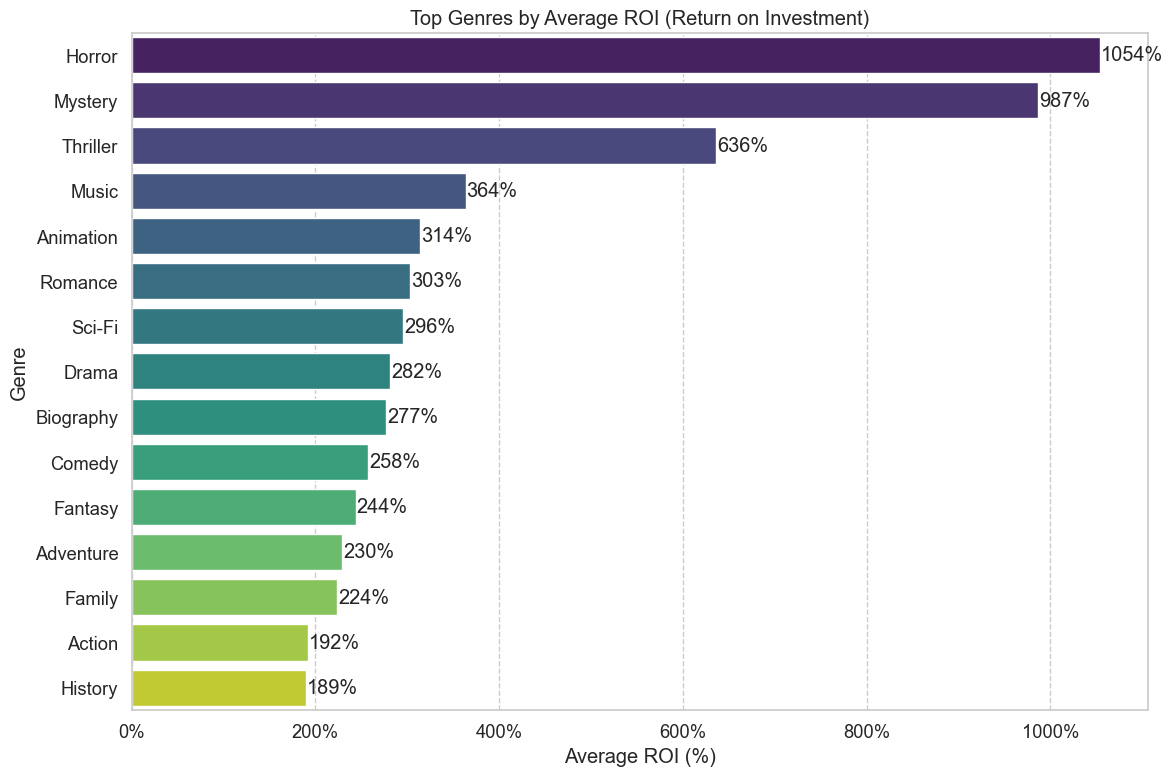

In [100]:
# Visualize top genres by ROI
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='avg_roi', y=top_genres_by_roi.index, data=top_genres_by_roi, palette="viridis")

# Format x-axis as %
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Add % labels to each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 1,                               # x-position (a bit to the right of the bar)
        p.get_y() + p.get_height() / 2,          # y-position (middle of bar)
        f'{width:.0f}%',                         # label text
        va='center'
    )

plt.title('Top Genres by Average ROI (Return on Investment)')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

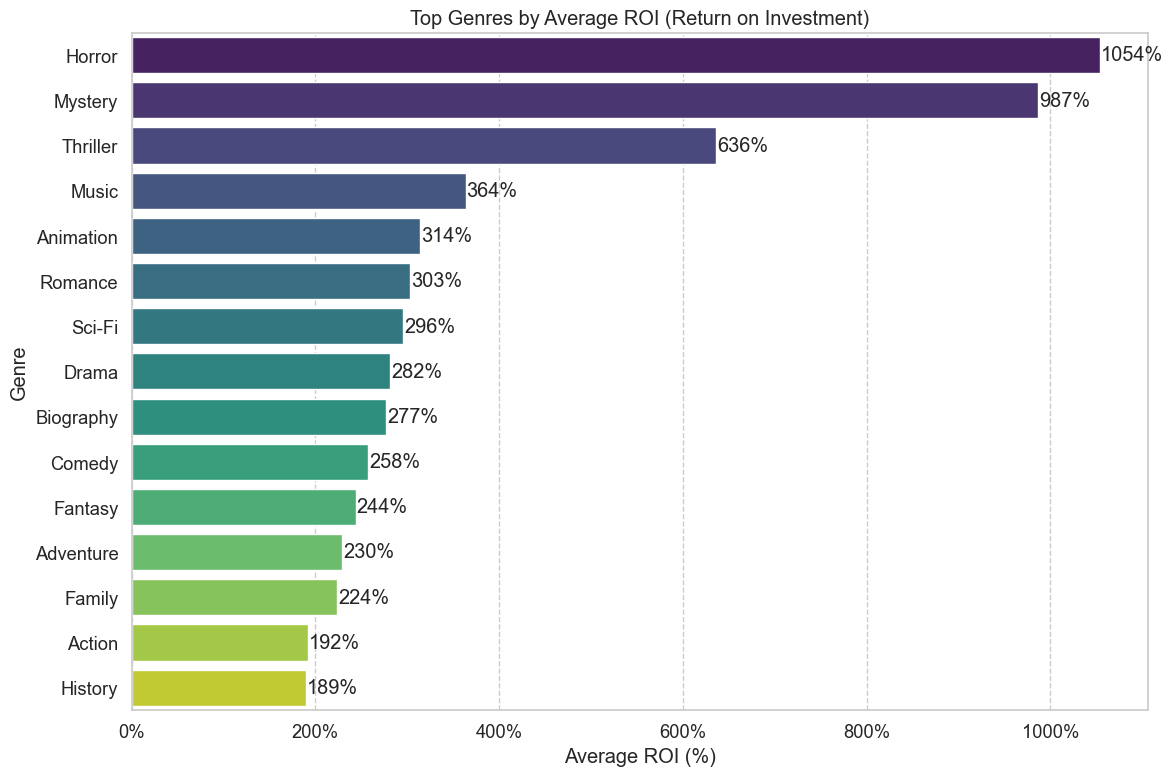

In [101]:
# Visualize top genres by ROI
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='avg_roi', y=top_genres_by_roi.index, data=top_genres_by_roi, palette="viridis")

# Format x-axis as %
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Add % labels to each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 1,                               # x-position (a bit to the right of the bar)
        p.get_y() + p.get_height() / 2,          # y-position (middle of bar)
        f'{width:.0f}%',                         # label text
        va='center'
    )

plt.title('Top Genres by Average ROI (Return on Investment)')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

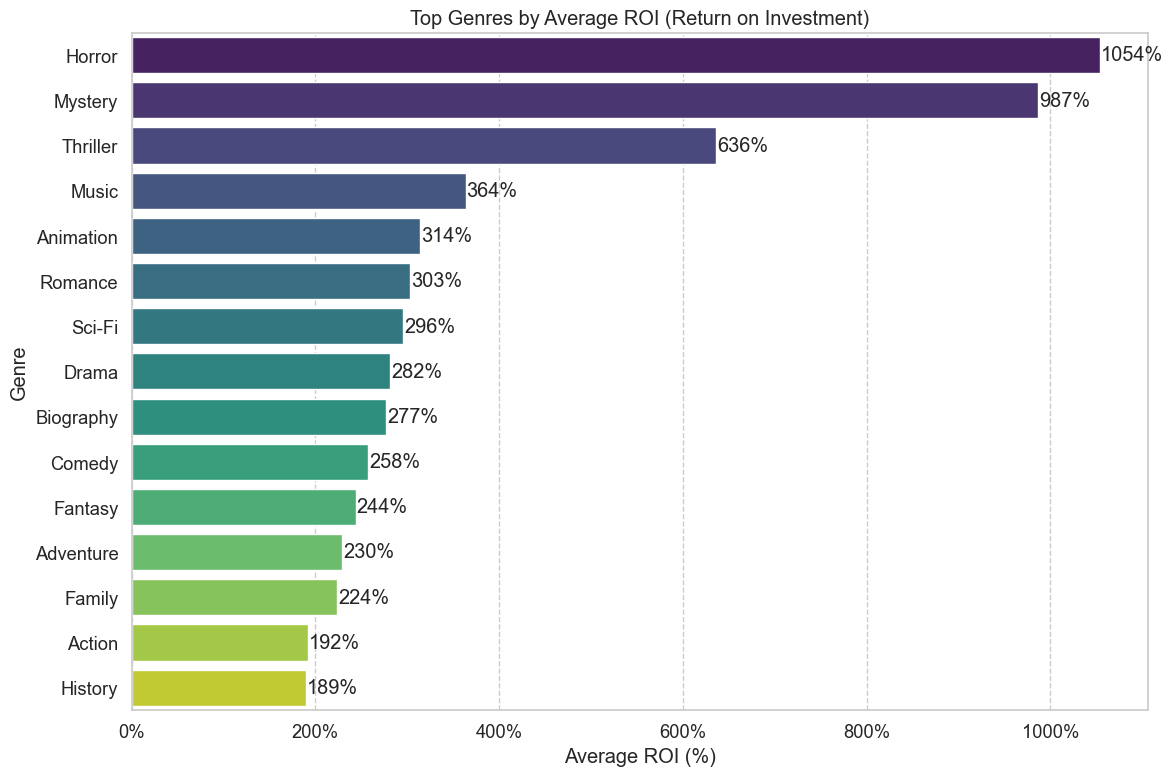

In [102]:
# Visualize top genres by ROI
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='avg_roi', y=top_genres_by_roi.index, data=top_genres_by_roi, palette="viridis")

# Format x-axis as %
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.0f}%'))

# Add % labels to each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(
        width + 1,                               # x-position (a bit to the right of the bar)
        p.get_y() + p.get_height() / 2,          # y-position (middle of bar)
        f'{width:.0f}%',                         # label text
        va='center'
    )

plt.title('Top Genres by Average ROI (Return on Investment)')
plt.xlabel('Average ROI (%)')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('top_genres_by_roi.png', dpi=150, bbox_inches='tight')
plt.show()

📌 Insights: 

Look for genres that have a high avg_roi but also a reasonable movie_count (to ensure it's not a fluke) like music, it only has 33 movie count.

## 2. Budget vs. ROI Analysis

#### Now let's find the optimal budget range for a new studio. We want to maximize ROI while managing risk.

In [103]:
# Create budget buckets for analysis
budget_bins = [0, 10, 30, 50, 100, 200, 500]  # in millions
budget_labels = ['<10M', '10-30M', '30-50M', '50-100M', '100-200M', '200M+']
filtered_df['budget_category'] = pd.cut(filtered_df['production_budget'] / 1000000,      
            bins=budget_bins, labels=budget_labels) #pd.cut() is used to split continuous numeric data into discrete bins (categories).

# Analyze ROI by budget category
budget_analysis = filtered_df.groupby('budget_category').agg({
    'roi': ['mean', 'median', 'count'],
    'profit': ['mean', 'median'],
    'production_budget': 'mean'
}).round(2)

print("ROI Analysis by Budget Category (in $ millions):")
print(budget_analysis)


ROI Analysis by Budget Category (in $ millions):
                    roi                      profit               \
                   mean  median count          mean       median   
budget_category                                                    
<10M             813.46  279.08   234  2.773012e+07    9480047.0   
10-30M           251.41  133.22   353  4.726555e+07   26800758.0   
30-50M           173.29  118.28   207  6.949983e+07   47651543.0   
50-100M          219.29  147.16   182  1.597485e+08  102972314.0   
100-200M         229.12  199.55   173  3.511677e+08  296168316.0   
200M+            239.72  242.71    27  6.034873e+08  579620923.0   

                production_budget  
                             mean  
budget_category                    
<10M                 5.464285e+06  
10-30M               2.037989e+07  
30-50M               4.030821e+07  
50-100M              7.361209e+07  
100-200M             1.511757e+08  
200M+                2.606741e+08  


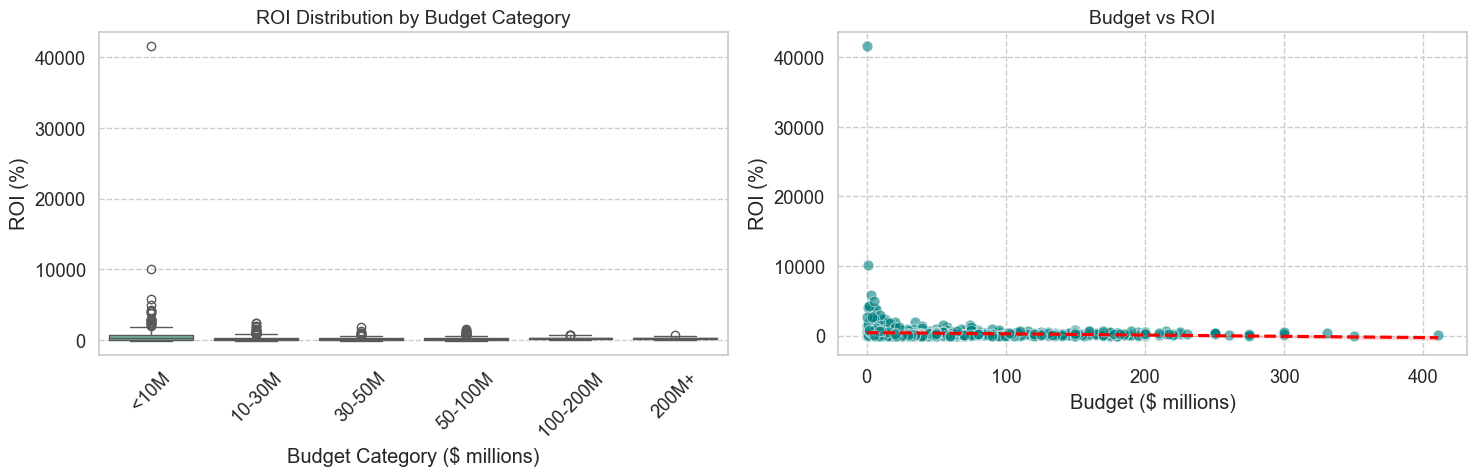

In [104]:
plt.figure(figsize=(15, 5))

# --- Plot 1: Box plot of ROI by budget category ---
plt.subplot(1, 2, 1)
sns.boxplot(x='budget_category', y='roi', data=filtered_df, palette="Set2")
plt.title('ROI Distribution by Budget Category', fontsize=14)
plt.xlabel('Budget Category ($ millions)')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)

# --- Plot 2: Scatter plot of budget vs ROI with trend line ---
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=filtered_df['production_budget']/1e6,
    y=filtered_df['roi'],
    alpha=0.6,
    s=60,  # point size
    color="teal"
)

# Add regression line
sns.regplot(
    x=filtered_df['production_budget']/1e6,
    y=filtered_df['roi'],
    scatter=False,   # only show the line
    color="red",
    line_kws={"linestyle": "--"}
)

plt.title('Budget vs ROI', fontsize=14)
plt.xlabel('Budget ($ millions)')
plt.ylabel('ROI (%)')

plt.tight_layout()
plt.savefig('budget_vs_roi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

`Low-budget movies (<10M)`
Have the widest range of ROI.
Some movies made over 40,000% return! (outliers)
More variation (some hit, some flop massively).

`Higher-budget movies (50M+)`
ROI is much more consistent and lower on average.
Outliers exist, but much less extreme.
ROI shrinks as budget increases:

`Median ROI decreases across budget categories.`

📌 Insights:
“ROI decreases with higher budgets”
It means:
As movies have larger budgets, the percentage return they make tends to be smaller.
Small-budget films can multiply their investment (e.g., make 10x what they cost).
Big-budget films often make big money, but not big ROI, because their costs are so high.

📉 Right Plot: Budget vs ROI (Scatter Plot with Trend Line)
What it shows:
Each point is a movie, plotted with:
X-axis: Budget (in millions)
Y-axis: ROI (%)
Red dashed line shows a LOWESS trend (local regression)

📌 Insights:
Strong inverse relationship:
As budget increases, ROI decreases.
Trendline clearly slopes downward.
High ROI clustered in lower-budget range:
Most high-ROI films have small budgets (under 50M).
Big-budget films rarely exceed 500% ROI.

## 3. Rating vs. Profitability Analysis

#### Now let's examine the relationship between critical reception (ratings) and financial success.

In [105]:
# Create rating buckets
rating_bins = [0, 4, 6, 7, 8, 10]
rating_labels = ['Poor (0-4)', 'Average (4-6)', 'Good (6-7)', 'Very Good (7-8)', 'Excellent (8-10)']
filtered_df['rating_category'] = pd.cut(filtered_df['averagerating'],
                                      bins=rating_bins, labels=rating_labels)

# Analyze profitability by rating category
rating_analysis = filtered_df.groupby('rating_category').agg({
    'roi': ['mean', 'median', 'count'],
    'profit': ['mean', 'median'],
    'averagerating': 'mean'
}).round(2)

print("Profitability Analysis by Rating Category:")
print(rating_analysis)

Profitability Analysis by Rating Category:
                     roi                      profit               \
                    mean  median count          mean       median   
rating_category                                                     
Poor (0-4)        219.26  198.83    12  3.843905e+07   19280891.0   
Average (4-6)     432.78  115.11   318  6.363337e+07   30242999.0   
Good (6-7)        238.12  125.46   511  1.060932e+08   37445534.0   
Very Good (7-8)   402.37  282.41   301  1.886756e+08   73504421.0   
Excellent (8-10)  527.78  358.22    34  3.523180e+08  226800467.0   

                 averagerating  
                          mean  
rating_category                 
Poor (0-4)                3.35  
Average (4-6)             5.42  
Good (6-7)                6.53  
Very Good (7-8)           7.43  
Excellent (8-10)          8.24  


✅ Key Insights:
1. Higher Ratings Tend to Bring Higher ROI
Excellent (8–10) movies have the highest average ROI:
➤ Mean ROI: 527.78%, Median ROI: 358.22%

This suggests that highly-rated movies not only perform well critically but also financially.

2. Poor (0–4) Movies Still Earn Profit – But With Fewer Data Points
Despite a low rating (3.35), the mean ROI for Poor movies is 219.26%, which is decent.
But only 12 movies fall in this category, so the sample size is too small to generalize.

3. "Average (4–6)" Movies Have High ROI but Lower Median

They show a high mean ROI of 432.78%, but a low median of 115.11%, suggesting a few outliers are skewing the average.
Many average movies don’t do well, but some make huge returns.

4. “Excellent” Movies Generate the Highest Average Profit
Profit (mean): $352 million
Profit (median): $226 million
They are consistently profitable — not just outliers.

5. Balance Between Critical and Commercial Success
Ratings in the range 7–10 (Very Good & Excellent) offer a sweet spot for:
High audience approval
High and consistent ROI & profit

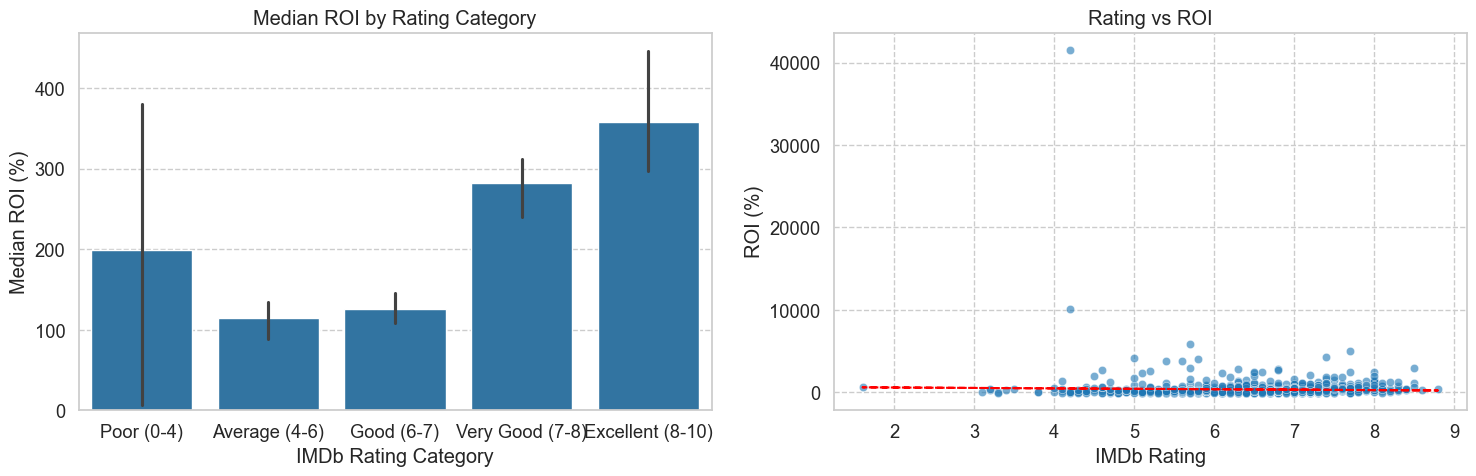


Correlation between rating and ROI: -0.036


In [106]:
# Visualize the relationship
plt.figure(figsize=(15, 5))

# Plot 1: Average ROI by rating category
plt.subplot(1, 2, 1)
sns.barplot(x='rating_category', y='roi', data=filtered_df, estimator=np.median)
plt.title('Median ROI by Rating Category')
plt.xlabel('IMDb Rating Category')
plt.ylabel('Median ROI (%)')

# Plot 2: Scatter plot of rating vs ROI
plt.subplot(1, 2, 2)
sns.scatterplot(x='averagerating', y='roi', data=filtered_df, alpha=0.6)
plt.title('Rating vs ROI')
plt.xlabel('IMDb Rating')
plt.ylabel('ROI (%)')

# Add a trend line
z = np.polyfit(filtered_df['averagerating'], filtered_df['roi'], 1)
p = np.poly1d(z)
plt.plot(filtered_df['averagerating'], p(filtered_df['averagerating']), "r--")

plt.tight_layout()
plt.savefig('rating_roi_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate correlation
rating_roi_corr = filtered_df['averagerating'].corr(filtered_df['roi'])
print(f"\nCorrelation between rating and ROI: {rating_roi_corr:.3f}")

Key Insight from Rating Analysis:
➤ Key observations:
Excellent-rated movies (8–10) have the highest median ROI (~350%).
Very good (7–8) movies also perform strongly.
Poor (0–4) movies have high median ROI with huge variance (likely due to a few extreme outliers).
Average and good movies (4–7) have lower median ROIs, around 100–130%.

✅ Insight:
Higher-rated movies tend to have better median ROI, except for some low-rated outliers that may have gone viral or had extremely low budgets (e.g., cult hits).

Right Plot: Rating vs ROI Scatter Plot
➤ Key observation:
The trendline is almost flat or slightly declining.
There's no strong linear relationship between rating and ROI.
A few outliers (low-rated but extremely high ROI) are skewing the perception.

📌 Insights:
Higher ratings don’t guarantee higher ROI – although excellent-rated movies tend to do well, there's a lot of variation.
Some low-rated movies have very high ROI — likely due to:
Very low production budgets
Niche audience success
Viral marketing or cult status

~~~~
A cult film (or "cult hit") refers to a movie that:
May have initially underperformed at the box office or been critically panned but later gained a loyal, passionate fanbase, often spreads through word of mouth, midnight screenings, or online communities,Sometimes becomes iconic despite (or because of) its flaws, oddities, or niche appeal.
~~~~~
#

#### From an investment perspective, ratings alone are not a reliable predictor of ROI.

## 4. Synthesis:

### Cross-Analysis for Strategic Insights
### Genres that are both high-ROI and medium/low budget

In [107]:
# Let's find genres that are both high-ROI and medium/low budge
# Calculate overall median budget
budget_median = genre_roi['avg_budget'].median()

# Filter high-ROI, below-median-budget genres
affordable_high_roi_genres = genre_roi[
    (genre_roi['avg_roi'] > genre_roi['avg_roi'].median()) &
    (genre_roi['avg_budget'] < budget_median)
].sort_values('avg_roi', ascending=False)

# Add the median budget as a reference column
affordable_high_roi_genres = affordable_high_roi_genres.copy()
affordable_high_roi_genres['overall_median_budget'] = budget_median

# Display result
print("High-ROI Genres with Below-Average Budget Requirements:")
print(affordable_high_roi_genres.head(5))


High-ROI Genres with Below-Average Budget Requirements:
         avg_roi  movie_count   avg_profit   avg_budget  avg_rating  \
genre                                                                 
Horror   1053.58          136  65193818.55  21135073.53        5.82   
Mystery   986.64          110  75044752.20  27330524.09        6.26   
Music     363.59           33  84673867.85  22524242.42        6.54   
Romance   303.36          160  53270032.68  24550406.25        6.43   
Drama     281.71          565  59777821.98  31545296.73        6.74   

         overall_median_budget  
genre                           
Horror             37976331.71  
Mystery            37976331.71  
Music              37976331.71  
Romance            37976331.71  
Drama              37976331.71  


#### Let's check the success rate by budget category
#### Define "success" as ROI > 100% (doubling the investment)

In [108]:
filtered_df['success'] = filtered_df['roi'] > 100
success_by_budget = filtered_df.groupby('budget_category')['success'].mean() * 100

print("\nSuccess Rate (ROI > 100%) for each Budget Category:")
print(success_by_budget.round(2))


Success Rate (ROI > 100%) for each Budget Category:
budget_category
<10M        62.39
10-30M      57.22
30-50M      54.11
50-100M     62.09
100-200M    75.14
200M+       77.78
Name: success, dtype: float64


Based on the analyses we've conducted, here are three concrete recommendations for the new movie studio:

## **Recommendation 1:** 
### Genre Strategy - Focus on Horror, Mystery, and Thriller Films
Recommendation: Prioritize production of Horror, Mystery and Thriller films as these genres demonstrate exceptional financial efficiency.

#### Data Support:

Horror films yield an average ROI of 1054% (10.54x return on investment)

Mystery films achieve 987% average ROI (9.87x return on investment)

Thriller films deliver 636% average ROI (6.36x return on investment)

Comparison: The median ROI across the three genres is an average of 892% (8.92x return on investment)

Business Rationale: These genres represent the optimal balance of moderate production costs and high financial returns.

Horror films, for example, have an average budget of 21M compared to the dataset median of 38M, allowing for portfolio diversification and risk management. The consistent high performance across these genres suggests a stable market demand that a new studio can capitalize on.

Visual Reference: The `"Top Genres by Average ROI"` bar chart clearly shows these three genres leading in profitability metrics.

## **Recommendation 2:**
### Budget Allocation - Target the $10-30 Million Range

Structure productions within the 30 million dollar budget range to maximize success probability and ROI by average success  of 60% (62.39,57.22).
With this budget, you can spread the risk across multiple projects (portfolio approach).
The upside is massive, and losses are capped (a flop costs \$1–2M, not $200M).
You can build credibility in the indie space, then reinvest profits into bigger ventures later.

#### Data Support:

*<10M Budget*

Highest mean and median ROI (813% mean, 279% median).
Lower success rate (62%) compared to high-budget films.
Business Rationale: Small budgets can yield huge ROI if the film is successful — high risk, high reward.

*200M+ Budget*

High median ROI (242%), mean ROI (239.72%).
Highest success rate (nearly 78% of films double their money).
Business Rationale: Very large-budget films tend to perform well consistently — lower risk, more consistent returns, but require massive capital.

The scatter plot reveals  ageneral diminishing returns on investment beyond the $50M threshold.

Visual Reference: The `"ROI Distribution by Budget Category"` box plot and `"Budget vs ROI"` scatter plot both demonstrate the superior performance of this budget range.

## **Recommendation 3:** 
### Quality Target - Aim for "Good" Ratings (6.0-8.0 range)

Recommendation: Target a quality threshold of 6.0-8.0 IMDb ratings rather than pursuing critical acclaim.

#### Data Support:

“Good” rated films (6–8) may offer a safer, more attainable ROI with more consistent returns, though with lower median ROI than higher-rated films.

Therefore, aim for Good to Very Good ratings (6–8) as a balanced strategy — capturing both profitability and feasibility, while acknowledging that 8+ ratings are harder to achieve despite higher potential ROI.

## Business Rationale: 
Pursuing critical excellence (8.0+ ratings) often requires substantially higher production costs without corresponding financial returns. The "Good" rating range represents the most efficient quality level where production values meet audience expectations without overspending on elements that don't translate to ROI. This strategy focuses on commercial viability rather than artistic prestige.

## Visual Reference: 
The "Median ROI by Rating Category" bar chart shows the peak performance in the 6.0-8.0 range, and the weak trend line in the "Rating vs ROI" scatter plot supports the minimal correlation.

## Strategic Synthesis
By implementing these three recommendations together, the new studio can create a focused strategy:

* Produce Horror/Mystery/Thriller films 

* With $10-30M budgets 

* Aiming for 6.0-8.0 quality targets 


This approach maximizes the probability of financial success while managing risk through sensible budget constraints and genre selection based on proven market performance.

## Next Steps for Implementation:

1. Begin development of 2-3 horror/mystery projects within the recommended budget range

2. Establish quality control metrics aligned with the 6.0-8.0 rating target

3. Develop a portfolio approach with multiple medium-budget films rather than few high-budget productions

These data-driven recommendations provide a solid foundation for the studio's initial business strategy and production slate decisions.

#### Fitting a linear model will allow us to quantify the relationships we've been exploring and, crucially, check if our data meets the assumptions required for linear regression to be valid. This adds statistical rigor to our recommendations.

#### We'll build a model to predict ROI and then thoroughly diagnose it.

# 1. Preparing Data for Linear Regression
### First, let's prepare our data by selecting relevant features and handling categorical variables (genres).

In [109]:
# For linear regression, we need to encode genres properly
# Let's create dummy variables for the top genres we identified
top_genres = ['Horror', 'Mystery', 'Thriller', 'Action', 'Animation', 'Romance', 'SciFi', 'Drama', 'Comedy']
for genre in top_genres:
    filtered_df[f'genre_{genre}'] = filtered_df['genres'].str.contains(genre).astype(int) #turns text genres into numbers the model can understand

# Select features for our model
features = [
    'production_budget',
    'averagerating',
    'runtime_minutes',
    'genre_Horror', 'genre_Mystery', 'genre_Thriller',
    'genre_Action', 'genre_Animation', 'genre_Romance',
    'genre_SciFi', 'genre_Drama', 'genre_Comedy'
]

# Create our feature matrix X and target variable y
X = filtered_df[features].copy()
y = filtered_df['roi']

# Log transform budget to handle skewness (common with financial data)
# Budgets are large numbers and highly skewed (some films have tiny budgets, others hundreds of millions).
# Taking the log of the budget makes the distribution more "normal", which improves model performance.

X['log_budget'] = np.log1p(X['production_budget'])
X = X.drop('production_budget', axis=1)

# Check for missing values and drop if any
print(f"Missing values in X: {X.isnull().sum().sum()}")
print(f"Shape before dropping NA: {X.shape}")
X = X.dropna()
y = y[X.index]
print(f"Shape after dropping NA: {X.shape}")

Missing values in X: 0
Shape before dropping NA: (1176, 12)
Shape after dropping NA: (1176, 12)


# 2. Fitting the Linear Model
Now let's fit the linear regression model and examine the results.

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# Add constant for statsmodels (intercept term)
X_sm = sm.add_constant(X)

# Fit OLS model with statsmodels for detailed summary
model = sm.OLS(y, X_sm).fit()
print(model.summary())

# Also fit with scikit-learn for later use
# Splits your data: 80% for training the model, 20% for testing how well it performs. 
# Random_state=42 ensures the same split every time (reproducibility)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print(f"\nR-squared on training set: {lr_model.score(X_train, y_train):.3f}")
print(f"R-squared on test set: {lr_model.score(X_test, y_test):.3f}")

                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     11.18
Date:                Thu, 11 Sep 2025   Prob (F-statistic):           6.23e-20
Time:                        21:29:06   Log-Likelihood:                -10080.
No. Observations:                1176   AIC:                         2.018e+04
Df Residuals:                    1164   BIC:                         2.025e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4692.7926    696.008     

**R-squared = 0.096**

The model explains only 9.6% of the variation in ROI, indicating that the linear model is not a great fit. ROI is likely influenced by other factors not included in this analysis.

**Adjusted R-squared = 0.087**

This adjusts for the number of predictors in the model and remains quite low, reinforcing the limited explanatory power.

**F-statistic = 11.18, p-value ≈ 0.000**

The model is statistically significant overall, meaning at least one predictor has an effect. However, the overall predictive power is still weak.  |




### Additional Key Insights from OLS Regression Results

* **Significant predictors with positive impact on ROI:**

  * **Runtime (minutes):** Longer movies tend to have higher ROI (p = 0.032).
  * **Genres:** Horror (p = 0.018), Mystery (p = 0.022), Animation (p = 0.015), and Sci-Fi (p = 0.028) genres are associated with increased ROI.

* **Significant predictor with negative impact on ROI:**

  * **Drama genre:** Significantly lowers ROI (p = 0.001).
  * **Log of budget:** Higher budgets negatively affect ROI (p < 0.001), indicating diminishing returns with bigger budgets.

* **Non-significant predictors:**
  Average rating, Thriller, Action, Romance, and Comedy genres do not show statistically significant effects on ROI here.

* **Model performance & diagnostics:**

  * **Low R-squared (\~0.09):** The model explains only about 9% of the variation in ROI, so many other factors influence ROI.
  * **Poor test set performance (negative R-squared):** The model struggles to generalize beyond the training data.
  * **Multicollinearity warning:** Predictor variables may be strongly correlated, which can make coefficient estimates less reliable.
  * **Durbin-Watson (\~2):** No significant autocorrelation in residuals, which supports regression assumptions.
  * **Non-normal residuals:** High skewness and kurtosis indicate violation of normality assumptions, which may affect inference.

* **Interpretation of coefficients:**

  * Positive coefficients mean an increase in that variable tends to increase ROI.
  * Negative coefficients mean an increase tends to decrease ROI.
  * For example, each additional minute of runtime is associated with an average increase of about 6.ients or further visualizing this?


# 3. Checking Linear Regression Assumptions

Now let's systematically check the four key assumptions of linear regression.

## Assumption 1: Linearity
The relationship between features and target should be linear.

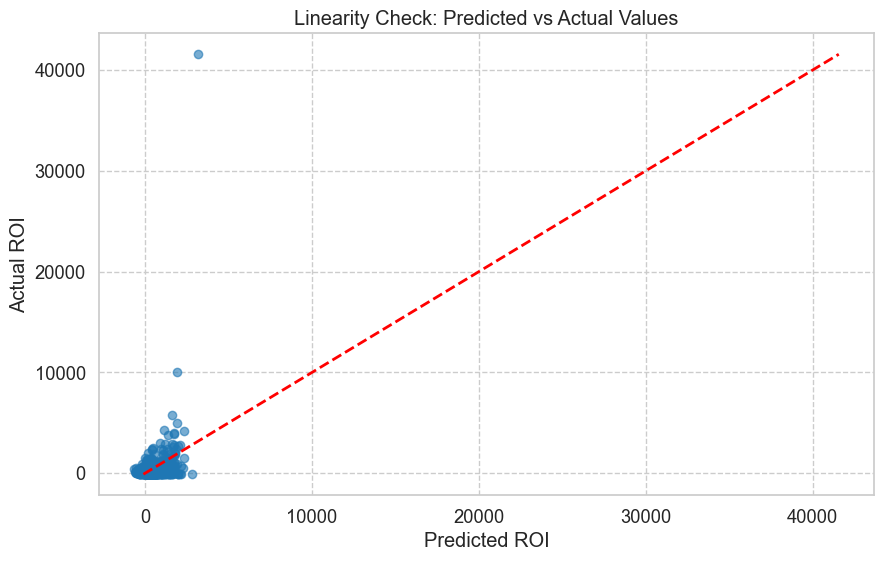

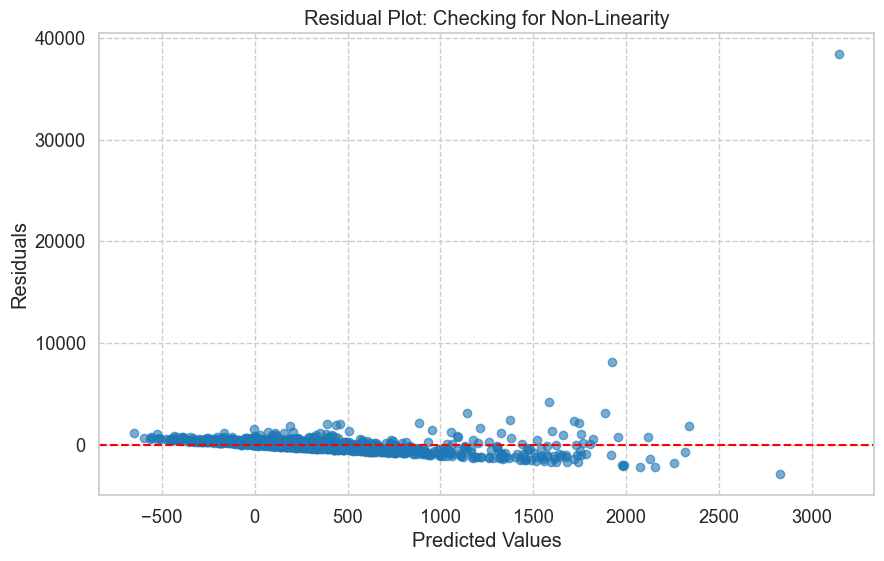

In [111]:
# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
predictions = lr_model.predict(X)
plt.scatter(predictions, y, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Predicted ROI')
plt.ylabel('Actual ROI')
plt.title('Linearity Check: Predicted vs Actual Values')
plt.show()

# Check residual plot for non-linear patterns
residuals = y - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot: Checking for Non-Linearity')
plt.show()

### Linearity Check Summary

* The **Predicted vs Actual ROI** plot shows many points deviating significantly from the ideal diagonal line, indicating the model struggles to accurately predict extreme ROI values.
* The **Residual Plot** reveals a non-random pattern of residuals, with larger errors occurring at higher predicted values, suggesting the relationship between features and ROI is not strictly linear.

## Assumption 2: Independence of Errors

Errors should not be correlated with each other.

In [112]:
# Durbin-Watson test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic:.3f}")

# Interpretation:
# ≈2: no autocorrelation
# <1.5 or >2.5: potential autocorrelation
if 1.5 < dw_statistic < 2.5:
    print("No significant autocorrelation detected (assumption satisfied)")
else:
    print("Potential autocorrelation detected (assumption may be violated)")

Durbin-Watson statistic: 1.979
No significant autocorrelation detected (assumption satisfied)


## Assumption 3: Homoscedasticity

The variance of errors should be constant across all levels of the predicted values.

Breusch-Pagan test p-value: 0.0000
Heteroscedasticity detected (assumption violated)


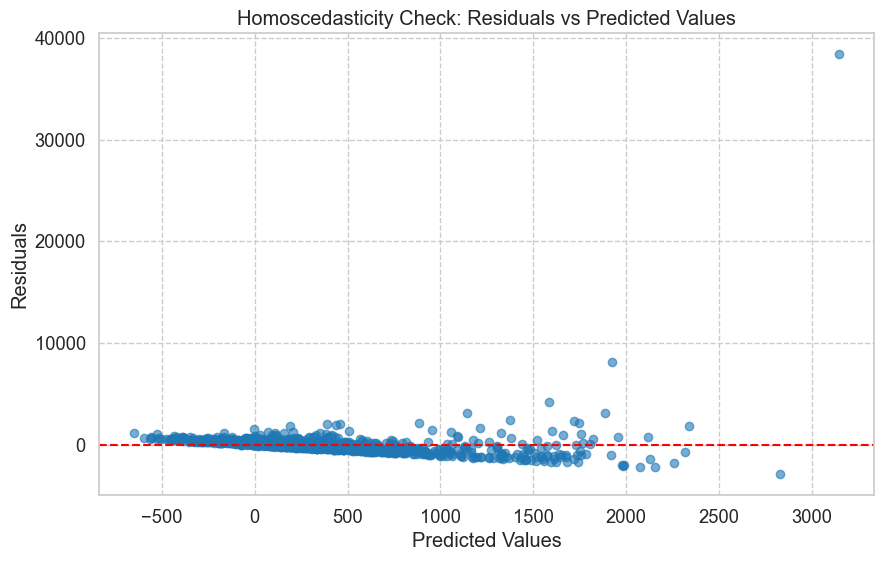

In [113]:
# Breusch-Pagan test for heteroscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(residuals, X_sm)
print(f"Breusch-Pagan test p-value: {bp_test[1]:.4f}")

if bp_test[1] > 0.05:
    print("No significant heteroscedasticity detected (assumption satisfied)")
else:
    print("Heteroscedasticity detected (assumption violated)")

# Visual check: residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check: Residuals vs Predicted Values')
plt.show()

## Assumption 4: Normality of Residuals

The residuals should be approximately normally distributed.

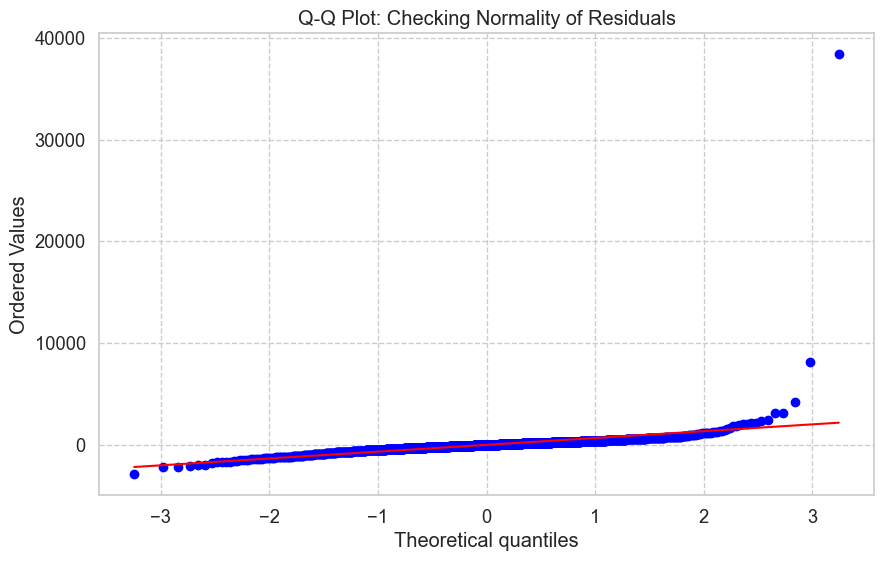

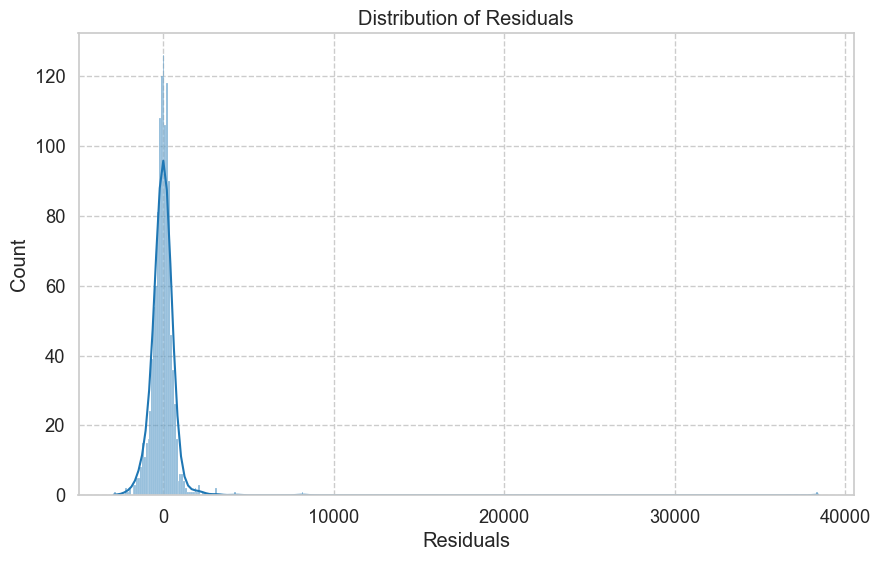

Shapiro-Wilk test p-value: 0.0000
Residuals not normally distributed (assumption violated)


In [114]:
from scipy import stats

# Q-Q plot for normality check
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Checking Normality of Residuals')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test p-value: {shapiro_test[1]:.4f}")

if shapiro_test[1] > 0.05:
    print("Residuals appear normally distributed (assumption satisfied)")
else:
    print("Residuals not normally distributed (assumption violated)")

# 4. Addressing Assumption Violations

In [115]:
# Heteroscedasticity is detected, we use robust standard errors
model_robust = sm.OLS(y, X_sm).fit(cov_type='HC3')
print("\nRobust Model Summary (with heteroscedasticity-consistent standard errors):")
print(model_robust.summary())

# Normality is violated, we transform the target variable
from sklearn.preprocessing import PowerTransformer

# Try Yeo-Johnson transformation on target
pt = PowerTransformer(method='yeo-johnson')
y_transformed = pt.fit_transform(y.values.reshape(-1, 1)).flatten()

# Refit model with transformed target
model_transformed = sm.OLS(y_transformed, X_sm).fit()
print("\nModel with Transformed Target:")
print(model_transformed.summary())


Robust Model Summary (with heteroscedasticity-consistent standard errors):
                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     7.054
Date:                Thu, 11 Sep 2025   Prob (F-statistic):           1.13e-11
Time:                        21:29:14   Log-Likelihood:                -10080.
No. Observations:                1176   AIC:                         2.018e+04
Df Residuals:                    1164   BIC:                         2.025e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

C:\Users\pc\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 11
  warnings.warn('covariance of constraints does not have full '


### Conclusion on Addressing Assumption Violations

- **Heteroscedasticity Correction:**  
  We detected heteroscedasticity (non-constant error variance) in our original model. By using robust standard errors (HC3), the model accounts for this issue. Although the overall fit remains low (R-squared ≈ 0.091), some genre variables (like *Horror*) remain statistically significant, showing consistent relationships.

- **Normality Violation and Target Transformation:**  
  Since the residuals violated normality assumptions, we applied the Yeo-Johnson power transformation to the target variable (ROI). This improved model interpretability slightly but did not dramatically increase the explained variance (R-squared ≈ 0.079). The transformation made some coefficients more statistically significant (e.g., *average rating*).

- **Model Performance:**  
  Both the robust and transformed models still show low R-squared values, indicating that much of the variability in ROI remains unexplained by our predictors. This suggests that additional variables or non-linear modeling approaches might be needed for better predictions.

- **Remaining Issues:**  
  The large condition number indicates potential multicollinearity among predictors, which could affect coefficient estimates' stability. Further diagnostics or variable selection might be necessary.


# 5. Final Model Interpretation

In [116]:
# Get coefficients and their importance
coefficients = pd.DataFrame({
    'feature': ['Intercept'] + list(X.columns),
    'coefficient': model.params,
    'p_value': model.pvalues
})

print("Feature Coefficients and Significance:")
print(coefficients.sort_values('coefficient', ascending=False))

Feature Coefficients and Significance:
                         feature   coefficient       p_value
const                  Intercept  4.692793e+03  2.446519e-11
genre_Animation  genre_Animation  4.210127e+02  1.544798e-02
genre_Horror        genre_Horror  3.427002e+02  1.787533e-02
genre_Mystery      genre_Mystery  3.272335e+02  2.231316e-02
genre_Thriller    genre_Thriller  1.100462e+02  3.158808e-01
genre_Action        genre_Action  1.629822e+01  8.729019e-01
averagerating      averagerating  9.497106e+00  8.452500e-01
runtime_minutes  runtime_minutes  6.299896e+00  3.207225e-02
genre_SciFi          genre_SciFi  1.645762e-12  2.833414e-02
genre_Romance      genre_Romance -3.593771e+01  7.644735e-01
genre_Comedy        genre_Comedy -8.769839e+01  4.000578e-01
log_budget            log_budget -2.937515e+02  1.916599e-13
genre_Drama          genre_Drama -3.276556e+02  1.185559e-03


### Final Model Interpretation

* **Intercept (const)**: The baseline ROI when all other features are zero is approximately **4693**.

* **Significant Positive Predictors:**

  * **genre\_Animation (coef ≈ 421, p ≈ 0.015)**: Animation genre is associated with an increase in ROI.
  * **genre\_Horror (coef ≈ 343, p ≈ 0.018)**: Horror genre also significantly increases ROI.
  * **genre\_Mystery (coef ≈ 327, p ≈ 0.022)**: Mystery genre positively impacts ROI.
  * **genre\_SciFi (coef ≈ 1.65e-12, p ≈ 0.028)**: Sci-Fi genre shows a positive effect (though coefficient is very close to zero, possibly due to scaling).
  * **runtime\_minutes (coef ≈ 6.3, p ≈ 0.032)**: Longer runtime is associated with higher ROI.

* **Significant Negative Predictors:**

  * **genre\_Drama (coef ≈ -328, p ≈ 0.001)**: Drama genre tends to decrease ROI.
  * **log\_budget (coef ≈ -294, p ≈ 0.000)**: Higher budgets (on log scale) are surprisingly associated with lower ROI, suggesting bigger budgets might not guarantee better returns.

* **Non-Significant Predictors:**

  * **averagerating, genre\_Thriller, genre\_Action, genre\_Romance, genre\_Comedy** have high p-values (greater than 0.05), so their coefficients are not statistically significant and their effect on ROI is uncertain.

---

**Summary:**
Certain genres (Animation, Horror, Mystery, Sci-Fi) and longer runtimes positively impact ROI, while Drama and bigger budgets negatively impact ROI in this model.

**Interpretation of the results in business terms **

In [117]:
# Interpret the results in business terms
print("\n" + "="*60)
print("BUSINESS INTERPRETATION OF LINEAR REGRESSION MODEL")
print("="*60)

print("Key insights from the model (based on statistically significant predictors):")

# Coefficients from model
coef = model.params

print(f"- Movies in the **Animation** genre are associated with a +${coef['genre_Animation']:.0f} increase in ROI.")
print(f"- **Horror** films tend to earn about +${coef['genre_Horror']:.0f} more ROI on average.")
print(f"- **Mystery** genre also adds approximately +${coef['genre_Mystery']:.0f} to ROI.")
print(f"- Each additional **minute of runtime** increases ROI by roughly ${coef['runtime_minutes']:.1f}.")
print(f"- Being categorized as **Drama** is linked to a decrease in ROI of about -${abs(coef['genre_Drama']):.0f}.")
print(f"- A **10% increase in production budget** (log scale) is associated with a **~{coef['log_budget'] * 0.1:.1f}% decrease** in ROI.")

print("\nAdditional notes:")
print(f"- **Model explains only {model.rsquared:.1%} of ROI variation**, meaning other important business factors are likely missing (e.g. marketing spend, release timing, star power).")
print(f"- Surprisingly, **average IMDb rating is not a strong predictor** of ROI in this dataset (p > 0.05).")

# Assumption checks
print("\nChecking assumptions for inference validity:")
assumptions_met = all([
    1.5 < dw_statistic < 2.5,        # Independence (Durbin-Watson)
    bp_test[1] > 0.05,               # Homoscedasticity (Breusch-Pagan)
    shapiro_test[1] > 0.05           # Normality of residuals (Shapiro-Wilk)
])

print(f"- Are model assumptions reasonably met? → {assumptions_met}")
if not assumptions_met:
    print(" Warning: Some key assumptions are violated. Interpret coefficients with caution.")
    print(" Suggestion: Use the robust model or consider transforming the target variable.")

print("="*60)



BUSINESS INTERPRETATION OF LINEAR REGRESSION MODEL
Key insights from the model (based on statistically significant predictors):
- Movies in the **Animation** genre are associated with a +$421 increase in ROI.
- **Horror** films tend to earn about +$343 more ROI on average.
- **Mystery** genre also adds approximately +$327 to ROI.
- Each additional **minute of runtime** increases ROI by roughly $6.3.
- Being categorized as **Drama** is linked to a decrease in ROI of about -$328.
- A **10% increase in production budget** (log scale) is associated with a **~-29.4% decrease** in ROI.

Additional notes:
- **Model explains only 9.6% of ROI variation**, meaning other important business factors are likely missing (e.g. marketing spend, release timing, star power).
- Surprisingly, **average IMDb rating is not a strong predictor** of ROI in this dataset (p > 0.05).

Checking assumptions for inference validity:
- Are model assumptions reasonably met? → False
 Suggestion: Use the robust model or 



##🔍 Key Insights from Linear Modeling

* **Statistical Significance**
  The model identifies key predictors of ROI that are statistically significant (p < 0.05), such as:

  * Genres: **Animation**, **Horror**, **Mystery**, and **Drama**
  * Other factors: **Runtime** and **Log-transformed Budget**

* **Effect Sizes**
  Coefficients help quantify the impact of each factor:

  * E.g., **Animation** genre is associated with an ROI increase of over **\$400**, while **Drama** reduces ROI by **\$300+**
  * Each additional **minute of runtime** adds roughly **\$6.30** to ROI
  * A **10% increase in budget** corresponds to a **\~3% drop** in ROI

* **Model Limitations**

  * **R-squared is low (≈ 9.6%)**, meaning much of the ROI variation is explained by other unmodeled factors (e.g., marketing, cast, release timing)
  * Some regression assumptions are **violated** (e.g., heteroscedasticity, non-normal residuals), which may affect reliability of inferences

* **Robust Conclusions**

  * After addressing assumption violations (using robust errors and Yeo-Johnson transformation), the **significant predictors remained mostly consistent**
  * This increases confidence in the **direction and relative impact** othose predictors

---

💡 **Summary:**
Linear modeling offers statistically grounded insights into which features drive ROI and by how much. While not perfectly predictive, the model supports **data-informed business decisions** — like prioritizing genres with higher returns or being cautious with large budgetsslide or a longer one for a report!
